In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
def to_onehot(data, n_digits):
    d = torch.tensor(data)
    y = torch.zeros(d.shape[0], n_digits).scatter(1,d[:,None],1)
    return y

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
root_folder = 'FC_CAAE_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [5]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [7]:
data, label = next(iter(train_loader))

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, bn=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [9]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [10]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [11]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [12]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10).to(device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10).to(device)

        fake_pred = Disc(Enc(data), label)
        true_pred = Disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent, label)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [13]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10).to(device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10).to(device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent, label)
            true_pred = Disc(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size
        
        if epoch % 100 == 0:
            fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
            plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
            fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
            plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6545, AE: 0.9230, D: 0.6833
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 3.7285, AE: 0.2837, D: 2.5597
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8769, AE: 0.2784, D: 1.2994
Test losses. E: 0.8706, AE: 0.2723, D: 1.3279
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8739, AE: 0.2696, D: 1.3033
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6377, AE: 0.2550, D: 0.9526
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.5210, AE: 0.2455, D: 0.8005
Test losses. E: 0.5001, AE: 0.2490, D: 0.7936
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.5175, AE: 0.2493, D: 0.7962
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 1.1594, AE: 0.2455, D: 0.8154
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5766, AE: 0.2277, D: 0.7942
Test losses. E: 0.5720, AE: 0.2319, D: 0.7892
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5753, AE: 0.2338, D: 0.8037
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.5605, AE: 0.2259, D: 0.7157
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.5291, 

Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.6645, AE: 0.1026, D: 0.7060
Test losses. E: 0.6579, AE: 0.1029, D: 0.7075
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.6639, AE: 0.1037, D: 0.7053
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.6857, AE: 0.0975, D: 0.6949
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.7044, AE: 0.0951, D: 0.6934
Test losses. E: 0.7034, AE: 0.0946, D: 0.6942
Train Epoch: 33 [0/50000 (0%)]	Losses E: 0.7032, AE: 0.0948, D: 0.6930
Train Epoch: 33 [25000/50000 (50%)]	Losses E: 0.6838, AE: 0.0904, D: 0.6916
Train Epoch: 33 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0895, D: 0.6902
Test losses. E: 0.6932, AE: 0.0907, D: 0.6909
Train Epoch: 34 [0/50000 (0%)]	Losses E: 0.6955, AE: 0.0957, D: 0.6906
Train Epoch: 34 [25000/50000 (50%)]	Losses E: 0.6904, AE: 0.1039, D: 0.6889
Train Epoch: 34 [50000/50000 (100%)]	Losses E: 0.7210, AE: 0.1022, D: 0.6826
Test losses. E: 0.7206, AE: 0.0965, D: 0.6848
Train Epoch: 35 [0/50000 (0%)]	Losses E: 0.7220, AE: 0.1000, D: 0.6

Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.6833, AE: 0.0876, D: 0.6995
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.6226, AE: 0.1115, D: 0.7197
Test losses. E: 0.6188, AE: 0.1045, D: 0.7154
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.6245, AE: 0.1031, D: 0.7179
Train Epoch: 63 [25000/50000 (50%)]	Losses E: 0.6767, AE: 0.0866, D: 0.6964
Train Epoch: 63 [50000/50000 (100%)]	Losses E: 0.6606, AE: 0.0891, D: 0.7209
Test losses. E: 0.6578, AE: 0.0860, D: 0.7175
Train Epoch: 64 [0/50000 (0%)]	Losses E: 0.6576, AE: 0.0829, D: 0.7175
Train Epoch: 64 [25000/50000 (50%)]	Losses E: 0.7093, AE: 0.0771, D: 0.6844
Train Epoch: 64 [50000/50000 (100%)]	Losses E: 0.6638, AE: 0.0825, D: 0.7001
Test losses. E: 0.6633, AE: 0.0811, D: 0.7006
Train Epoch: 65 [0/50000 (0%)]	Losses E: 0.6632, AE: 0.0771, D: 0.7016
Train Epoch: 65 [25000/50000 (50%)]	Losses E: 0.7522, AE: 0.0784, D: 0.6941
Train Epoch: 65 [50000/50000 (100%)]	Losses E: 0.6798, AE: 0.0740, D: 0.6925
Test losses. E: 0.6796, AE: 0.0760, D

Test losses. E: 0.6829, AE: 0.0628, D: 0.6936
Train Epoch: 93 [0/50000 (0%)]	Losses E: 0.6846, AE: 0.0611, D: 0.6949
Train Epoch: 93 [25000/50000 (50%)]	Losses E: 0.6809, AE: 0.0636, D: 0.6935
Train Epoch: 93 [50000/50000 (100%)]	Losses E: 0.6780, AE: 0.0621, D: 0.6948
Test losses. E: 0.6768, AE: 0.0629, D: 0.6947
Train Epoch: 94 [0/50000 (0%)]	Losses E: 0.6787, AE: 0.0603, D: 0.6947
Train Epoch: 94 [25000/50000 (50%)]	Losses E: 0.6868, AE: 0.0618, D: 0.6942
Train Epoch: 94 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0573, D: 0.6933
Test losses. E: 0.6956, AE: 0.0634, D: 0.6949
Train Epoch: 95 [0/50000 (0%)]	Losses E: 0.6968, AE: 0.0638, D: 0.6968
Train Epoch: 95 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0601, D: 0.6947
Train Epoch: 95 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0617, D: 0.6931
Test losses. E: 0.6960, AE: 0.0599, D: 0.6916
Train Epoch: 96 [0/50000 (0%)]	Losses E: 0.6948, AE: 0.0554, D: 0.6944
Train Epoch: 96 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.0630, D: 0.69

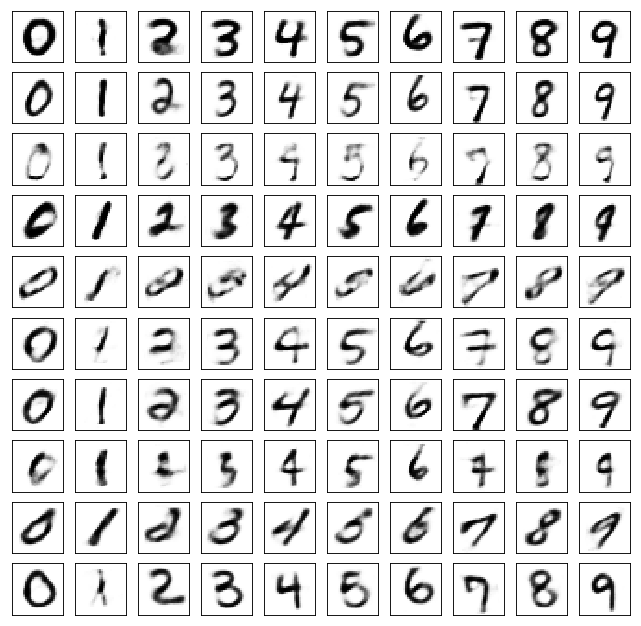

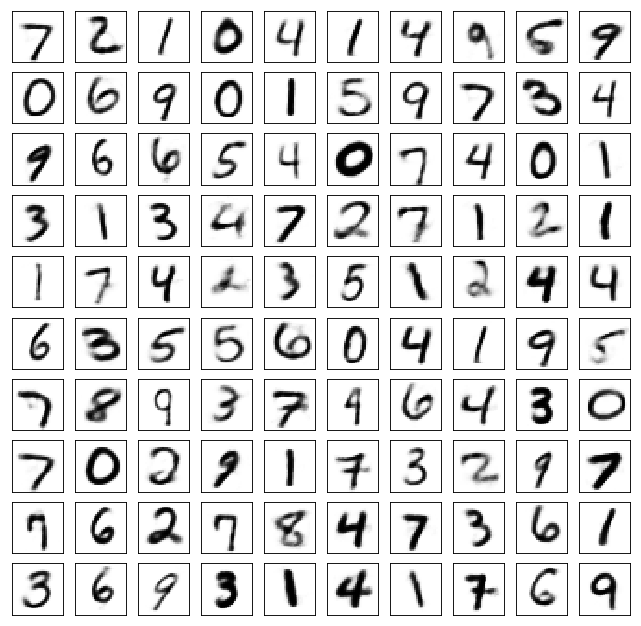

Test losses. E: 0.6942, AE: 0.0589, D: 0.6917
Train Epoch: 101 [0/50000 (0%)]	Losses E: 0.6949, AE: 0.0546, D: 0.6937
Train Epoch: 101 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0590, D: 0.6947
Train Epoch: 101 [50000/50000 (100%)]	Losses E: 0.6907, AE: 0.0602, D: 0.6963
Test losses. E: 0.6934, AE: 0.0613, D: 0.6938
Train Epoch: 102 [0/50000 (0%)]	Losses E: 0.6930, AE: 0.0560, D: 0.6918
Train Epoch: 102 [25000/50000 (50%)]	Losses E: 0.6901, AE: 0.0569, D: 0.6918
Train Epoch: 102 [50000/50000 (100%)]	Losses E: 0.6902, AE: 0.0552, D: 0.6930
Test losses. E: 0.6888, AE: 0.0591, D: 0.6931
Train Epoch: 103 [0/50000 (0%)]	Losses E: 0.6871, AE: 0.0579, D: 0.6941
Train Epoch: 103 [25000/50000 (50%)]	Losses E: 0.6893, AE: 0.0556, D: 0.6929
Train Epoch: 103 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0566, D: 0.6965
Test losses. E: 0.6963, AE: 0.0598, D: 0.6945
Train Epoch: 104 [0/50000 (0%)]	Losses E: 0.6975, AE: 0.0564, D: 0.6908
Train Epoch: 104 [25000/50000 (50%)]	Losses E: 0.6991, AE: 0.05

Train Epoch: 131 [25000/50000 (50%)]	Losses E: 0.6921, AE: 0.0483, D: 0.6930
Train Epoch: 131 [50000/50000 (100%)]	Losses E: 0.7028, AE: 0.0513, D: 0.6926
Test losses. E: 0.7019, AE: 0.0532, D: 0.6920
Train Epoch: 132 [0/50000 (0%)]	Losses E: 0.7040, AE: 0.0454, D: 0.6909
Train Epoch: 132 [25000/50000 (50%)]	Losses E: 0.6975, AE: 0.0475, D: 0.6923
Train Epoch: 132 [50000/50000 (100%)]	Losses E: 0.6891, AE: 0.0439, D: 0.6909
Test losses. E: 0.6897, AE: 0.0521, D: 0.6917
Train Epoch: 133 [0/50000 (0%)]	Losses E: 0.6858, AE: 0.0482, D: 0.6931
Train Epoch: 133 [25000/50000 (50%)]	Losses E: 0.6905, AE: 0.0490, D: 0.6948
Train Epoch: 133 [50000/50000 (100%)]	Losses E: 0.6951, AE: 0.0505, D: 0.6945
Test losses. E: 0.6942, AE: 0.0537, D: 0.6940
Train Epoch: 134 [0/50000 (0%)]	Losses E: 0.6954, AE: 0.0466, D: 0.6945
Train Epoch: 134 [25000/50000 (50%)]	Losses E: 0.6936, AE: 0.0477, D: 0.6937
Train Epoch: 134 [50000/50000 (100%)]	Losses E: 0.6858, AE: 0.0486, D: 0.6917
Test losses. E: 0.6856, AE

Train Epoch: 161 [50000/50000 (100%)]	Losses E: 0.6917, AE: 0.0456, D: 0.6928
Test losses. E: 0.6908, AE: 0.0502, D: 0.6918
Train Epoch: 162 [0/50000 (0%)]	Losses E: 0.6898, AE: 0.0418, D: 0.6931
Train Epoch: 162 [25000/50000 (50%)]	Losses E: 0.6915, AE: 0.0451, D: 0.6913
Train Epoch: 162 [50000/50000 (100%)]	Losses E: 0.6834, AE: 0.0462, D: 0.6916
Test losses. E: 0.6842, AE: 0.0504, D: 0.6925
Train Epoch: 163 [0/50000 (0%)]	Losses E: 0.6845, AE: 0.0430, D: 0.6915
Train Epoch: 163 [25000/50000 (50%)]	Losses E: 0.7001, AE: 0.0398, D: 0.6934
Train Epoch: 163 [50000/50000 (100%)]	Losses E: 0.6994, AE: 0.0440, D: 0.6912
Test losses. E: 0.6976, AE: 0.0505, D: 0.6938
Train Epoch: 164 [0/50000 (0%)]	Losses E: 0.6990, AE: 0.0435, D: 0.6930
Train Epoch: 164 [25000/50000 (50%)]	Losses E: 0.6849, AE: 0.0498, D: 0.6931
Train Epoch: 164 [50000/50000 (100%)]	Losses E: 0.6910, AE: 0.0458, D: 0.6923
Test losses. E: 0.6876, AE: 0.0503, D: 0.6929
Train Epoch: 165 [0/50000 (0%)]	Losses E: 0.6858, AE: 0.0

Test losses. E: 0.6927, AE: 0.0491, D: 0.6929
Train Epoch: 192 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0400, D: 0.6937
Train Epoch: 192 [25000/50000 (50%)]	Losses E: 0.7012, AE: 0.0442, D: 0.6954
Train Epoch: 192 [50000/50000 (100%)]	Losses E: 0.6792, AE: 0.0420, D: 0.6954
Test losses. E: 0.6809, AE: 0.0495, D: 0.6935
Train Epoch: 193 [0/50000 (0%)]	Losses E: 0.6787, AE: 0.0424, D: 0.6932
Train Epoch: 193 [25000/50000 (50%)]	Losses E: 0.6977, AE: 0.0421, D: 0.6948
Train Epoch: 193 [50000/50000 (100%)]	Losses E: 0.6961, AE: 0.0401, D: 0.6939
Test losses. E: 0.6961, AE: 0.0491, D: 0.6921
Train Epoch: 194 [0/50000 (0%)]	Losses E: 0.6952, AE: 0.0408, D: 0.6945
Train Epoch: 194 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0405, D: 0.6899
Train Epoch: 194 [50000/50000 (100%)]	Losses E: 0.6876, AE: 0.0405, D: 0.6930
Test losses. E: 0.6844, AE: 0.0493, D: 0.6930
Train Epoch: 195 [0/50000 (0%)]	Losses E: 0.6826, AE: 0.0411, D: 0.6936
Train Epoch: 195 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.04

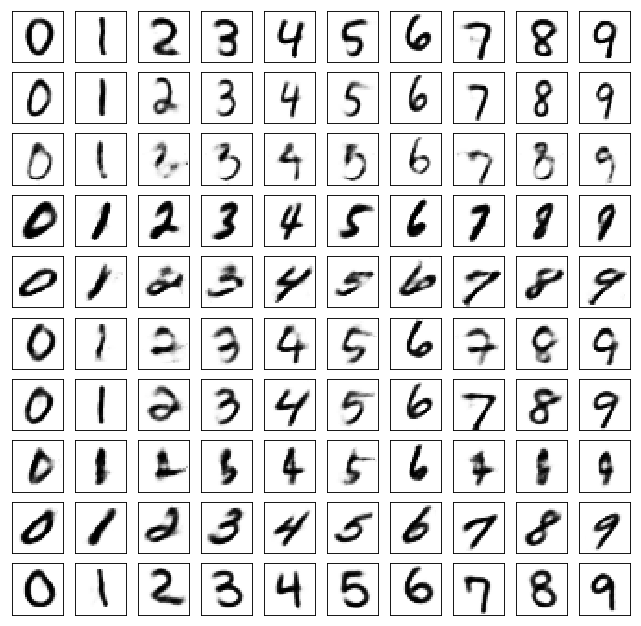

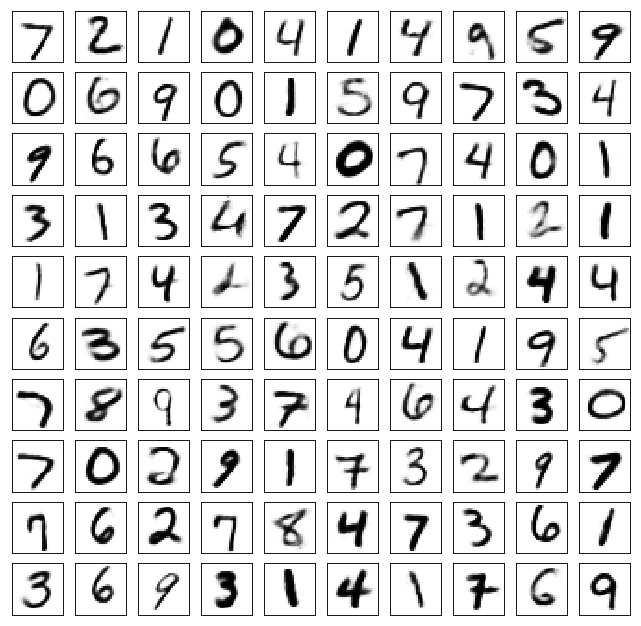

Test losses. E: 0.7017, AE: 0.0480, D: 0.6922
Train Epoch: 201 [0/50000 (0%)]	Losses E: 0.7030, AE: 0.0390, D: 0.6924
Train Epoch: 201 [25000/50000 (50%)]	Losses E: 0.7032, AE: 0.0397, D: 0.6918
Train Epoch: 201 [50000/50000 (100%)]	Losses E: 0.6997, AE: 0.0413, D: 0.6926
Test losses. E: 0.7009, AE: 0.0488, D: 0.6920
Train Epoch: 202 [0/50000 (0%)]	Losses E: 0.7003, AE: 0.0406, D: 0.6942
Train Epoch: 202 [25000/50000 (50%)]	Losses E: 0.6916, AE: 0.0373, D: 0.6923
Train Epoch: 202 [50000/50000 (100%)]	Losses E: 0.6937, AE: 0.0408, D: 0.6940
Test losses. E: 0.6949, AE: 0.0496, D: 0.6928
Train Epoch: 203 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0409, D: 0.6942
Train Epoch: 203 [25000/50000 (50%)]	Losses E: 0.6941, AE: 0.0408, D: 0.6930
Train Epoch: 203 [50000/50000 (100%)]	Losses E: 0.6924, AE: 0.0381, D: 0.6932
Test losses. E: 0.6941, AE: 0.0485, D: 0.6924
Train Epoch: 204 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0408, D: 0.6937
Train Epoch: 204 [25000/50000 (50%)]	Losses E: 0.6936, AE: 0.03

Train Epoch: 231 [25000/50000 (50%)]	Losses E: 0.6865, AE: 0.0381, D: 0.6918
Train Epoch: 231 [50000/50000 (100%)]	Losses E: 0.7095, AE: 0.0349, D: 0.6926
Test losses. E: 0.7079, AE: 0.0478, D: 0.6919
Train Epoch: 232 [0/50000 (0%)]	Losses E: 0.7088, AE: 0.0355, D: 0.6918
Train Epoch: 232 [25000/50000 (50%)]	Losses E: 0.6987, AE: 0.0403, D: 0.6959
Train Epoch: 232 [50000/50000 (100%)]	Losses E: 0.6879, AE: 0.0396, D: 0.6925
Test losses. E: 0.6898, AE: 0.0474, D: 0.6924
Train Epoch: 233 [0/50000 (0%)]	Losses E: 0.6918, AE: 0.0365, D: 0.6892
Train Epoch: 233 [25000/50000 (50%)]	Losses E: 0.6924, AE: 0.0369, D: 0.6905
Train Epoch: 233 [50000/50000 (100%)]	Losses E: 0.6937, AE: 0.0356, D: 0.6914
Test losses. E: 0.6930, AE: 0.0471, D: 0.6921
Train Epoch: 234 [0/50000 (0%)]	Losses E: 0.6934, AE: 0.0355, D: 0.6930
Train Epoch: 234 [25000/50000 (50%)]	Losses E: 0.7032, AE: 0.0354, D: 0.6918
Train Epoch: 234 [50000/50000 (100%)]	Losses E: 0.6963, AE: 0.0371, D: 0.6941
Test losses. E: 0.6962, AE

Train Epoch: 261 [50000/50000 (100%)]	Losses E: 0.6976, AE: 0.0370, D: 0.6927
Test losses. E: 0.6985, AE: 0.0479, D: 0.6929
Train Epoch: 262 [0/50000 (0%)]	Losses E: 0.6986, AE: 0.0365, D: 0.6954
Train Epoch: 262 [25000/50000 (50%)]	Losses E: 0.7035, AE: 0.0356, D: 0.6934
Train Epoch: 262 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0352, D: 0.6923
Test losses. E: 0.6959, AE: 0.0480, D: 0.6933
Train Epoch: 263 [0/50000 (0%)]	Losses E: 0.7002, AE: 0.0348, D: 0.6941
Train Epoch: 263 [25000/50000 (50%)]	Losses E: 0.6911, AE: 0.0363, D: 0.6933
Train Epoch: 263 [50000/50000 (100%)]	Losses E: 0.6898, AE: 0.0356, D: 0.6930
Test losses. E: 0.6906, AE: 0.0469, D: 0.6922
Train Epoch: 264 [0/50000 (0%)]	Losses E: 0.6895, AE: 0.0335, D: 0.6940
Train Epoch: 264 [25000/50000 (50%)]	Losses E: 0.6917, AE: 0.0361, D: 0.6934
Train Epoch: 264 [50000/50000 (100%)]	Losses E: 0.7047, AE: 0.0346, D: 0.6925
Test losses. E: 0.7035, AE: 0.0475, D: 0.6920
Train Epoch: 265 [0/50000 (0%)]	Losses E: 0.7037, AE: 0.0

Test losses. E: 0.7010, AE: 0.0474, D: 0.6927
Train Epoch: 292 [0/50000 (0%)]	Losses E: 0.7024, AE: 0.0347, D: 0.6915
Train Epoch: 292 [25000/50000 (50%)]	Losses E: 0.7023, AE: 0.0347, D: 0.6911
Train Epoch: 292 [50000/50000 (100%)]	Losses E: 0.7008, AE: 0.0338, D: 0.6924
Test losses. E: 0.7004, AE: 0.0472, D: 0.6925
Train Epoch: 293 [0/50000 (0%)]	Losses E: 0.7012, AE: 0.0325, D: 0.6909
Train Epoch: 293 [25000/50000 (50%)]	Losses E: 0.6865, AE: 0.0344, D: 0.6939
Train Epoch: 293 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0342, D: 0.6914
Test losses. E: 0.6931, AE: 0.0474, D: 0.6922
Train Epoch: 294 [0/50000 (0%)]	Losses E: 0.6908, AE: 0.0346, D: 0.6931
Train Epoch: 294 [25000/50000 (50%)]	Losses E: 0.6980, AE: 0.0333, D: 0.6943
Train Epoch: 294 [50000/50000 (100%)]	Losses E: 0.7028, AE: 0.0332, D: 0.6898
Test losses. E: 0.7029, AE: 0.0470, D: 0.6921
Train Epoch: 295 [0/50000 (0%)]	Losses E: 0.7036, AE: 0.0335, D: 0.6928
Train Epoch: 295 [25000/50000 (50%)]	Losses E: 0.6996, AE: 0.03

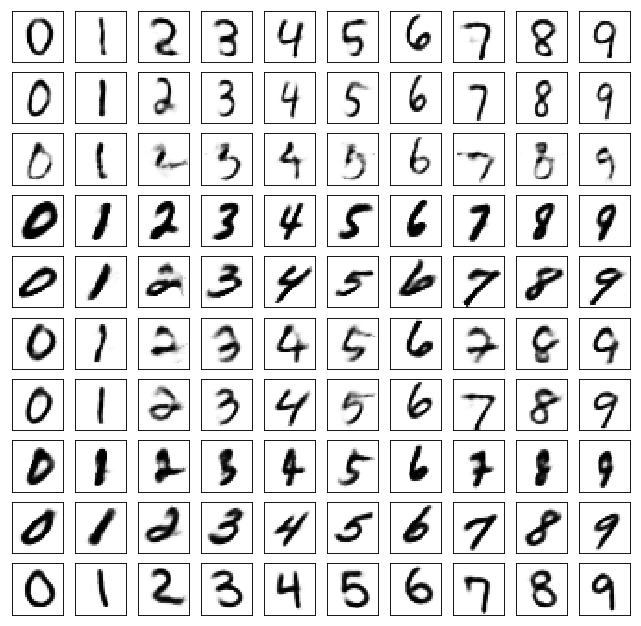

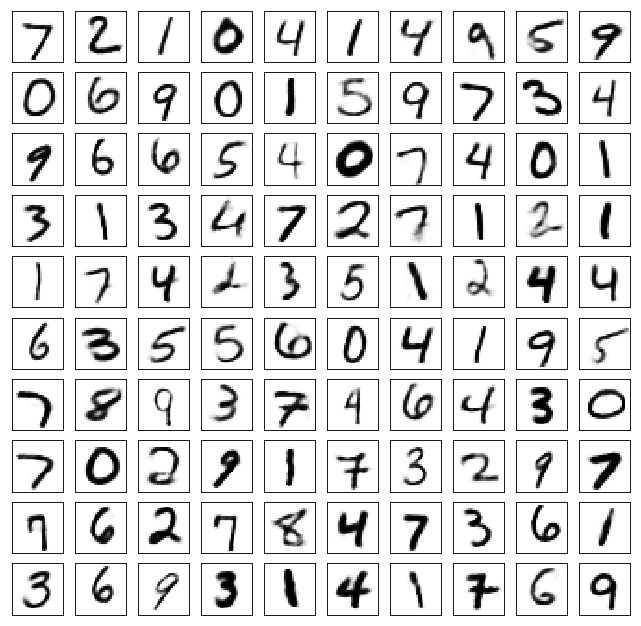

Test losses. E: 0.6926, AE: 0.0467, D: 0.6920
Train Epoch: 301 [0/50000 (0%)]	Losses E: 0.6912, AE: 0.0344, D: 0.6940
Train Epoch: 301 [25000/50000 (50%)]	Losses E: 0.7045, AE: 0.0325, D: 0.6910
Train Epoch: 301 [50000/50000 (100%)]	Losses E: 0.6908, AE: 0.0348, D: 0.6921
Test losses. E: 0.6909, AE: 0.0471, D: 0.6924
Train Epoch: 302 [0/50000 (0%)]	Losses E: 0.6916, AE: 0.0325, D: 0.6918
Train Epoch: 302 [25000/50000 (50%)]	Losses E: 0.6885, AE: 0.0345, D: 0.6941
Train Epoch: 302 [50000/50000 (100%)]	Losses E: 0.6936, AE: 0.0341, D: 0.6947
Test losses. E: 0.6952, AE: 0.0478, D: 0.6929
Train Epoch: 303 [0/50000 (0%)]	Losses E: 0.6941, AE: 0.0351, D: 0.6912
Train Epoch: 303 [25000/50000 (50%)]	Losses E: 0.6992, AE: 0.0342, D: 0.6919
Train Epoch: 303 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.0327, D: 0.6928
Test losses. E: 0.6958, AE: 0.0473, D: 0.6924
Train Epoch: 304 [0/50000 (0%)]	Losses E: 0.6970, AE: 0.0301, D: 0.6926
Train Epoch: 304 [25000/50000 (50%)]	Losses E: 0.7013, AE: 0.03

Train Epoch: 331 [25000/50000 (50%)]	Losses E: 0.7022, AE: 0.0305, D: 0.6914
Train Epoch: 331 [50000/50000 (100%)]	Losses E: 0.6896, AE: 0.0351, D: 0.6964
Test losses. E: 0.6888, AE: 0.0475, D: 0.6928
Train Epoch: 332 [0/50000 (0%)]	Losses E: 0.6883, AE: 0.0327, D: 0.6919
Train Epoch: 332 [25000/50000 (50%)]	Losses E: 0.6893, AE: 0.0330, D: 0.6930
Train Epoch: 332 [50000/50000 (100%)]	Losses E: 0.6972, AE: 0.0333, D: 0.6941
Test losses. E: 0.6983, AE: 0.0477, D: 0.6927
Train Epoch: 333 [0/50000 (0%)]	Losses E: 0.7001, AE: 0.0343, D: 0.6910
Train Epoch: 333 [25000/50000 (50%)]	Losses E: 0.6991, AE: 0.0337, D: 0.6932
Train Epoch: 333 [50000/50000 (100%)]	Losses E: 0.6949, AE: 0.0312, D: 0.6909
Test losses. E: 0.6902, AE: 0.0467, D: 0.6918
Train Epoch: 334 [0/50000 (0%)]	Losses E: 0.6904, AE: 0.0316, D: 0.6912
Train Epoch: 334 [25000/50000 (50%)]	Losses E: 0.6971, AE: 0.0313, D: 0.6940
Train Epoch: 334 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0340, D: 0.6926
Test losses. E: 0.6956, AE

Train Epoch: 361 [50000/50000 (100%)]	Losses E: 0.6919, AE: 0.0308, D: 0.6925
Test losses. E: 0.6930, AE: 0.0475, D: 0.6926
Train Epoch: 362 [0/50000 (0%)]	Losses E: 0.6938, AE: 0.0341, D: 0.6911
Train Epoch: 362 [25000/50000 (50%)]	Losses E: 0.6995, AE: 0.0323, D: 0.6926
Train Epoch: 362 [50000/50000 (100%)]	Losses E: 0.6890, AE: 0.0343, D: 0.6951
Test losses. E: 0.6893, AE: 0.0477, D: 0.6929
Train Epoch: 363 [0/50000 (0%)]	Losses E: 0.6902, AE: 0.0306, D: 0.6930
Train Epoch: 363 [25000/50000 (50%)]	Losses E: 0.6915, AE: 0.0316, D: 0.6949
Train Epoch: 363 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0296, D: 0.6927
Test losses. E: 0.6890, AE: 0.0472, D: 0.6922
Train Epoch: 364 [0/50000 (0%)]	Losses E: 0.6883, AE: 0.0315, D: 0.6938
Train Epoch: 364 [25000/50000 (50%)]	Losses E: 0.6928, AE: 0.0314, D: 0.6926
Train Epoch: 364 [50000/50000 (100%)]	Losses E: 0.6929, AE: 0.0295, D: 0.6921
Test losses. E: 0.6927, AE: 0.0467, D: 0.6920
Train Epoch: 365 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0

Test losses. E: 0.6895, AE: 0.0477, D: 0.6919
Train Epoch: 392 [0/50000 (0%)]	Losses E: 0.6945, AE: 0.0279, D: 0.6907
Train Epoch: 392 [25000/50000 (50%)]	Losses E: 0.6902, AE: 0.0299, D: 0.6928
Train Epoch: 392 [50000/50000 (100%)]	Losses E: 0.6926, AE: 0.0328, D: 0.6942
Test losses. E: 0.6946, AE: 0.0471, D: 0.6921
Train Epoch: 393 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0315, D: 0.6936
Train Epoch: 393 [25000/50000 (50%)]	Losses E: 0.6857, AE: 0.0296, D: 0.6920
Train Epoch: 393 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0289, D: 0.6895
Test losses. E: 0.6904, AE: 0.0470, D: 0.6921
Train Epoch: 394 [0/50000 (0%)]	Losses E: 0.6889, AE: 0.0305, D: 0.6925
Train Epoch: 394 [25000/50000 (50%)]	Losses E: 0.6902, AE: 0.0300, D: 0.6938
Train Epoch: 394 [50000/50000 (100%)]	Losses E: 0.6854, AE: 0.0303, D: 0.6904
Test losses. E: 0.6846, AE: 0.0475, D: 0.6917
Train Epoch: 395 [0/50000 (0%)]	Losses E: 0.6859, AE: 0.0280, D: 0.6929
Train Epoch: 395 [25000/50000 (50%)]	Losses E: 0.6764, AE: 0.03

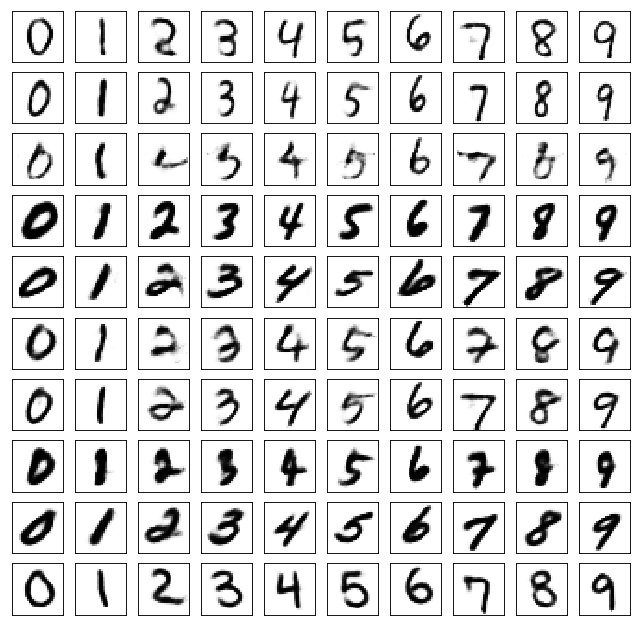

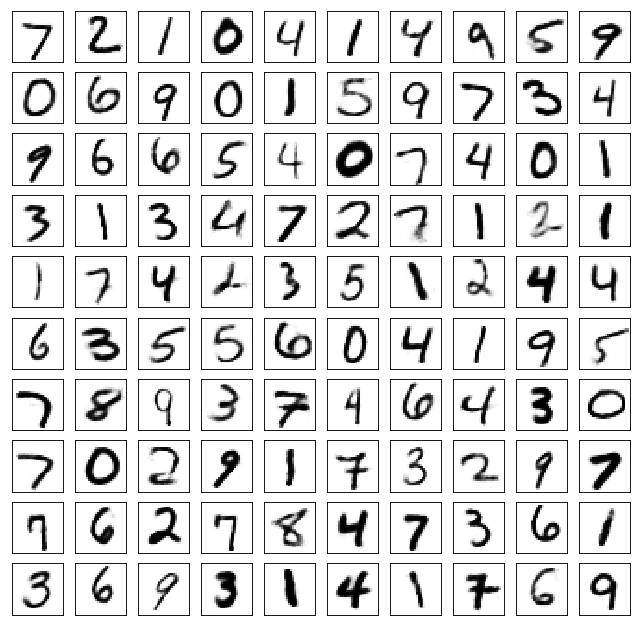

Test losses. E: 0.6938, AE: 0.0475, D: 0.6926
Train Epoch: 401 [0/50000 (0%)]	Losses E: 0.6945, AE: 0.0297, D: 0.6948
Train Epoch: 401 [25000/50000 (50%)]	Losses E: 0.6882, AE: 0.0305, D: 0.6939
Train Epoch: 401 [50000/50000 (100%)]	Losses E: 0.6860, AE: 0.0315, D: 0.6930
Test losses. E: 0.6872, AE: 0.0475, D: 0.6924
Train Epoch: 402 [0/50000 (0%)]	Losses E: 0.6867, AE: 0.0306, D: 0.6938
Train Epoch: 402 [25000/50000 (50%)]	Losses E: 0.6817, AE: 0.0301, D: 0.6943
Train Epoch: 402 [50000/50000 (100%)]	Losses E: 0.6851, AE: 0.0288, D: 0.6941
Test losses. E: 0.6819, AE: 0.0475, D: 0.6927
Train Epoch: 403 [0/50000 (0%)]	Losses E: 0.6825, AE: 0.0309, D: 0.6938
Train Epoch: 403 [25000/50000 (50%)]	Losses E: 0.6931, AE: 0.0311, D: 0.6917
Train Epoch: 403 [50000/50000 (100%)]	Losses E: 0.6909, AE: 0.0327, D: 0.6910
Test losses. E: 0.6889, AE: 0.0474, D: 0.6928
Train Epoch: 404 [0/50000 (0%)]	Losses E: 0.6948, AE: 0.0286, D: 0.6924
Train Epoch: 404 [25000/50000 (50%)]	Losses E: 0.6941, AE: 0.02

Train Epoch: 431 [25000/50000 (50%)]	Losses E: 0.6863, AE: 0.0298, D: 0.6934
Train Epoch: 431 [50000/50000 (100%)]	Losses E: 0.6891, AE: 0.0296, D: 0.6929
Test losses. E: 0.6877, AE: 0.0478, D: 0.6916
Train Epoch: 432 [0/50000 (0%)]	Losses E: 0.6875, AE: 0.0302, D: 0.6921
Train Epoch: 432 [25000/50000 (50%)]	Losses E: 0.6848, AE: 0.0303, D: 0.6915
Train Epoch: 432 [50000/50000 (100%)]	Losses E: 0.6882, AE: 0.0303, D: 0.6947
Test losses. E: 0.6897, AE: 0.0474, D: 0.6919
Train Epoch: 433 [0/50000 (0%)]	Losses E: 0.6883, AE: 0.0289, D: 0.6927
Train Epoch: 433 [25000/50000 (50%)]	Losses E: 0.6973, AE: 0.0283, D: 0.6901
Train Epoch: 433 [50000/50000 (100%)]	Losses E: 0.6974, AE: 0.0322, D: 0.6956
Test losses. E: 0.6990, AE: 0.0479, D: 0.6926
Train Epoch: 434 [0/50000 (0%)]	Losses E: 0.6986, AE: 0.0307, D: 0.6922
Train Epoch: 434 [25000/50000 (50%)]	Losses E: 0.7044, AE: 0.0284, D: 0.6945
Train Epoch: 434 [50000/50000 (100%)]	Losses E: 0.7015, AE: 0.0313, D: 0.6916
Test losses. E: 0.6995, AE

Train Epoch: 461 [50000/50000 (100%)]	Losses E: 0.6909, AE: 0.0295, D: 0.6916
Test losses. E: 0.6915, AE: 0.0479, D: 0.6924
Train Epoch: 462 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0271, D: 0.6923
Train Epoch: 462 [25000/50000 (50%)]	Losses E: 0.6884, AE: 0.0295, D: 0.6924
Train Epoch: 462 [50000/50000 (100%)]	Losses E: 0.6856, AE: 0.0300, D: 0.6924
Test losses. E: 0.6837, AE: 0.0481, D: 0.6924
Train Epoch: 463 [0/50000 (0%)]	Losses E: 0.6846, AE: 0.0272, D: 0.6926
Train Epoch: 463 [25000/50000 (50%)]	Losses E: 0.6937, AE: 0.0289, D: 0.6937
Train Epoch: 463 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0299, D: 0.6935
Test losses. E: 0.6987, AE: 0.0481, D: 0.6923
Train Epoch: 464 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0292, D: 0.6942
Train Epoch: 464 [25000/50000 (50%)]	Losses E: 0.6927, AE: 0.0309, D: 0.6930
Train Epoch: 464 [50000/50000 (100%)]	Losses E: 0.6973, AE: 0.0289, D: 0.6921
Test losses. E: 0.6972, AE: 0.0481, D: 0.6920
Train Epoch: 465 [0/50000 (0%)]	Losses E: 0.6969, AE: 0.0

Test losses. E: 0.6972, AE: 0.0483, D: 0.6925
Train Epoch: 492 [0/50000 (0%)]	Losses E: 0.6945, AE: 0.0278, D: 0.6946
Train Epoch: 492 [25000/50000 (50%)]	Losses E: 0.6858, AE: 0.0270, D: 0.6927
Train Epoch: 492 [50000/50000 (100%)]	Losses E: 0.6910, AE: 0.0304, D: 0.6921
Test losses. E: 0.6916, AE: 0.0485, D: 0.6922
Train Epoch: 493 [0/50000 (0%)]	Losses E: 0.6935, AE: 0.0267, D: 0.6909
Train Epoch: 493 [25000/50000 (50%)]	Losses E: 0.7014, AE: 0.0258, D: 0.6917
Train Epoch: 493 [50000/50000 (100%)]	Losses E: 0.6920, AE: 0.0297, D: 0.6932
Test losses. E: 0.6927, AE: 0.0481, D: 0.6923
Train Epoch: 494 [0/50000 (0%)]	Losses E: 0.6937, AE: 0.0286, D: 0.6931
Train Epoch: 494 [25000/50000 (50%)]	Losses E: 0.6952, AE: 0.0301, D: 0.6934
Train Epoch: 494 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0294, D: 0.6931
Test losses. E: 0.6950, AE: 0.0481, D: 0.6924
Train Epoch: 495 [0/50000 (0%)]	Losses E: 0.6968, AE: 0.0293, D: 0.6914
Train Epoch: 495 [25000/50000 (50%)]	Losses E: 0.6969, AE: 0.02

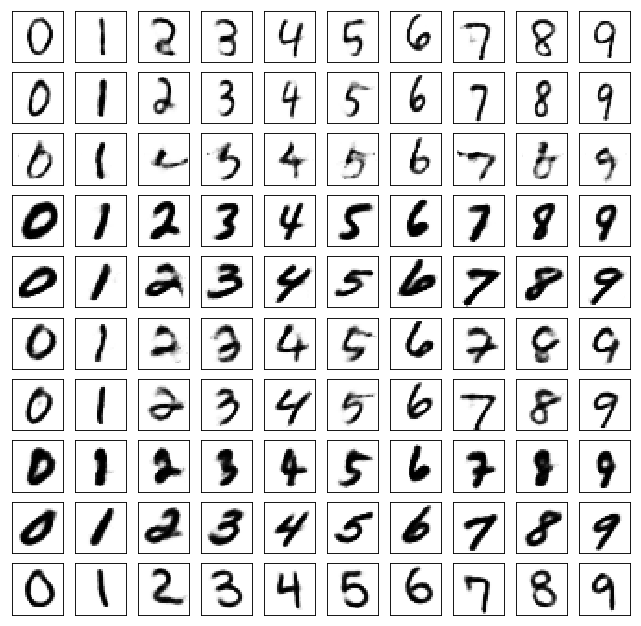

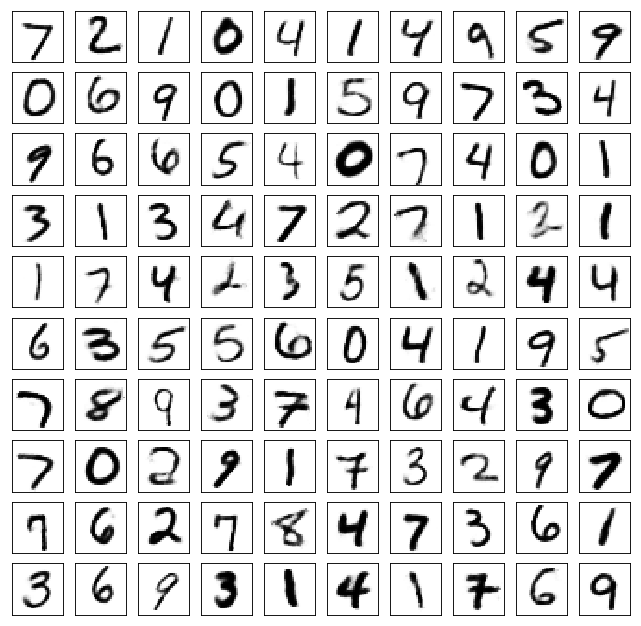

Test losses. E: 0.6941, AE: 0.0478, D: 0.6922
Train Epoch: 501 [0/50000 (0%)]	Losses E: 0.6965, AE: 0.0262, D: 0.6946
Train Epoch: 501 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0267, D: 0.6893
Train Epoch: 501 [50000/50000 (100%)]	Losses E: 0.6848, AE: 0.0265, D: 0.6951
Test losses. E: 0.6860, AE: 0.0480, D: 0.6926
Train Epoch: 502 [0/50000 (0%)]	Losses E: 0.6818, AE: 0.0279, D: 0.6943
Train Epoch: 502 [25000/50000 (50%)]	Losses E: 0.6853, AE: 0.0278, D: 0.6928
Train Epoch: 502 [50000/50000 (100%)]	Losses E: 0.6891, AE: 0.0304, D: 0.6947
Test losses. E: 0.6891, AE: 0.0489, D: 0.6928
Train Epoch: 503 [0/50000 (0%)]	Losses E: 0.6906, AE: 0.0288, D: 0.6918
Train Epoch: 503 [25000/50000 (50%)]	Losses E: 0.6864, AE: 0.0277, D: 0.6911
Train Epoch: 503 [50000/50000 (100%)]	Losses E: 0.6892, AE: 0.0279, D: 0.6917
Test losses. E: 0.6868, AE: 0.0482, D: 0.6928
Train Epoch: 504 [0/50000 (0%)]	Losses E: 0.6895, AE: 0.0292, D: 0.6924
Train Epoch: 504 [25000/50000 (50%)]	Losses E: 0.7010, AE: 0.02

Train Epoch: 531 [25000/50000 (50%)]	Losses E: 0.6918, AE: 0.0279, D: 0.6921
Train Epoch: 531 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0286, D: 0.6935
Test losses. E: 0.6961, AE: 0.0487, D: 0.6923
Train Epoch: 532 [0/50000 (0%)]	Losses E: 0.6982, AE: 0.0261, D: 0.6923
Train Epoch: 532 [25000/50000 (50%)]	Losses E: 0.6948, AE: 0.0287, D: 0.6931
Train Epoch: 532 [50000/50000 (100%)]	Losses E: 0.6880, AE: 0.0283, D: 0.6957
Test losses. E: 0.6886, AE: 0.0482, D: 0.6921
Train Epoch: 533 [0/50000 (0%)]	Losses E: 0.6901, AE: 0.0288, D: 0.6922
Train Epoch: 533 [25000/50000 (50%)]	Losses E: 0.6971, AE: 0.0268, D: 0.6925
Train Epoch: 533 [50000/50000 (100%)]	Losses E: 0.6905, AE: 0.0280, D: 0.6922
Test losses. E: 0.6891, AE: 0.0483, D: 0.6924
Train Epoch: 534 [0/50000 (0%)]	Losses E: 0.6848, AE: 0.0277, D: 0.6926
Train Epoch: 534 [25000/50000 (50%)]	Losses E: 0.6904, AE: 0.0282, D: 0.6916
Train Epoch: 534 [50000/50000 (100%)]	Losses E: 0.6883, AE: 0.0279, D: 0.6928
Test losses. E: 0.6909, AE

Train Epoch: 561 [50000/50000 (100%)]	Losses E: 0.6900, AE: 0.0271, D: 0.6923
Test losses. E: 0.6879, AE: 0.0487, D: 0.6923
Train Epoch: 562 [0/50000 (0%)]	Losses E: 0.6856, AE: 0.0269, D: 0.6910
Train Epoch: 562 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0268, D: 0.6922
Train Epoch: 562 [50000/50000 (100%)]	Losses E: 0.6948, AE: 0.0266, D: 0.6920
Test losses. E: 0.6940, AE: 0.0484, D: 0.6922
Train Epoch: 563 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0251, D: 0.6923
Train Epoch: 563 [25000/50000 (50%)]	Losses E: 0.6951, AE: 0.0269, D: 0.6908
Train Epoch: 563 [50000/50000 (100%)]	Losses E: 0.6934, AE: 0.0261, D: 0.6951
Test losses. E: 0.6915, AE: 0.0486, D: 0.6923
Train Epoch: 564 [0/50000 (0%)]	Losses E: 0.6876, AE: 0.0261, D: 0.6959
Train Epoch: 564 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0296, D: 0.6947
Train Epoch: 564 [50000/50000 (100%)]	Losses E: 0.6906, AE: 0.0269, D: 0.6929
Test losses. E: 0.6909, AE: 0.0491, D: 0.6927
Train Epoch: 565 [0/50000 (0%)]	Losses E: 0.6909, AE: 0.0

Test losses. E: 0.6857, AE: 0.0487, D: 0.6920
Train Epoch: 592 [0/50000 (0%)]	Losses E: 0.6897, AE: 0.0253, D: 0.6913
Train Epoch: 592 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0256, D: 0.6872
Train Epoch: 592 [50000/50000 (100%)]	Losses E: 0.7006, AE: 0.0275, D: 0.6936
Test losses. E: 0.6996, AE: 0.0488, D: 0.6922
Train Epoch: 593 [0/50000 (0%)]	Losses E: 0.7026, AE: 0.0260, D: 0.6917
Train Epoch: 593 [25000/50000 (50%)]	Losses E: 0.7047, AE: 0.0254, D: 0.6888
Train Epoch: 593 [50000/50000 (100%)]	Losses E: 0.6980, AE: 0.0264, D: 0.6922
Test losses. E: 0.6980, AE: 0.0493, D: 0.6922
Train Epoch: 594 [0/50000 (0%)]	Losses E: 0.6975, AE: 0.0261, D: 0.6959
Train Epoch: 594 [25000/50000 (50%)]	Losses E: 0.6945, AE: 0.0256, D: 0.6934
Train Epoch: 594 [50000/50000 (100%)]	Losses E: 0.6903, AE: 0.0277, D: 0.6918
Test losses. E: 0.6887, AE: 0.0488, D: 0.6924
Train Epoch: 595 [0/50000 (0%)]	Losses E: 0.6878, AE: 0.0255, D: 0.6952
Train Epoch: 595 [25000/50000 (50%)]	Losses E: 0.6892, AE: 0.02

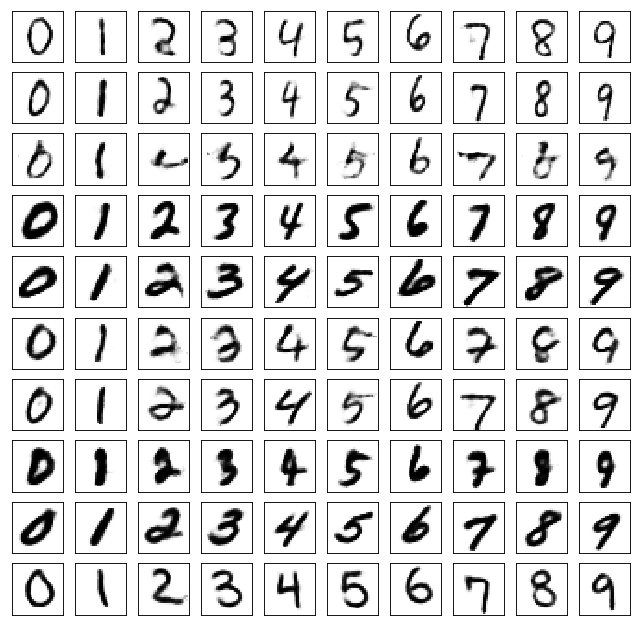

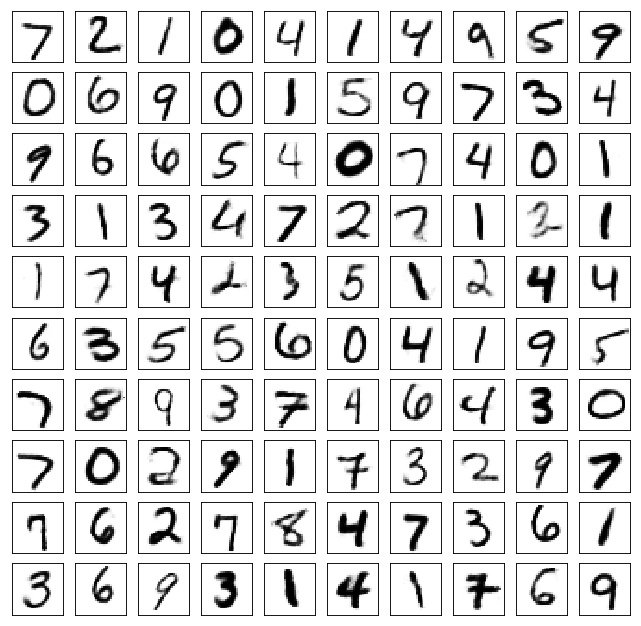

Test losses. E: 0.7039, AE: 0.0489, D: 0.6921
Train Epoch: 601 [0/50000 (0%)]	Losses E: 0.7057, AE: 0.0278, D: 0.6918
Train Epoch: 601 [25000/50000 (50%)]	Losses E: 0.6997, AE: 0.0273, D: 0.6924
Train Epoch: 601 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0266, D: 0.6915
Test losses. E: 0.6937, AE: 0.0489, D: 0.6923
Train Epoch: 602 [0/50000 (0%)]	Losses E: 0.6949, AE: 0.0282, D: 0.6915
Train Epoch: 602 [25000/50000 (50%)]	Losses E: 0.6908, AE: 0.0258, D: 0.6923
Train Epoch: 602 [50000/50000 (100%)]	Losses E: 0.6882, AE: 0.0253, D: 0.6894
Test losses. E: 0.6872, AE: 0.0487, D: 0.6923
Train Epoch: 603 [0/50000 (0%)]	Losses E: 0.6856, AE: 0.0267, D: 0.6967
Train Epoch: 603 [25000/50000 (50%)]	Losses E: 0.6925, AE: 0.0269, D: 0.6928
Train Epoch: 603 [50000/50000 (100%)]	Losses E: 0.6990, AE: 0.0274, D: 0.6942
Test losses. E: 0.6997, AE: 0.0491, D: 0.6922
Train Epoch: 604 [0/50000 (0%)]	Losses E: 0.7007, AE: 0.0245, D: 0.6933
Train Epoch: 604 [25000/50000 (50%)]	Losses E: 0.7031, AE: 0.02

Train Epoch: 631 [25000/50000 (50%)]	Losses E: 0.6932, AE: 0.0266, D: 0.6931
Train Epoch: 631 [50000/50000 (100%)]	Losses E: 0.6942, AE: 0.0255, D: 0.6944
Test losses. E: 0.6928, AE: 0.0492, D: 0.6922
Train Epoch: 632 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0262, D: 0.6922
Train Epoch: 632 [25000/50000 (50%)]	Losses E: 0.6979, AE: 0.0249, D: 0.6919
Train Epoch: 632 [50000/50000 (100%)]	Losses E: 0.6900, AE: 0.0259, D: 0.6922
Test losses. E: 0.6901, AE: 0.0492, D: 0.6924
Train Epoch: 633 [0/50000 (0%)]	Losses E: 0.6931, AE: 0.0245, D: 0.6944
Train Epoch: 633 [25000/50000 (50%)]	Losses E: 0.7009, AE: 0.0255, D: 0.6919
Train Epoch: 633 [50000/50000 (100%)]	Losses E: 0.6923, AE: 0.0250, D: 0.6916
Test losses. E: 0.6909, AE: 0.0490, D: 0.6922
Train Epoch: 634 [0/50000 (0%)]	Losses E: 0.6908, AE: 0.0245, D: 0.6926
Train Epoch: 634 [25000/50000 (50%)]	Losses E: 0.6986, AE: 0.0241, D: 0.6925
Train Epoch: 634 [50000/50000 (100%)]	Losses E: 0.6953, AE: 0.0256, D: 0.6920
Test losses. E: 0.6931, AE

Train Epoch: 661 [50000/50000 (100%)]	Losses E: 0.7012, AE: 0.0254, D: 0.6926
Test losses. E: 0.6981, AE: 0.0494, D: 0.6926
Train Epoch: 662 [0/50000 (0%)]	Losses E: 0.6999, AE: 0.0242, D: 0.6917
Train Epoch: 662 [25000/50000 (50%)]	Losses E: 0.6979, AE: 0.0257, D: 0.6933
Train Epoch: 662 [50000/50000 (100%)]	Losses E: 0.7024, AE: 0.0248, D: 0.6936
Test losses. E: 0.7016, AE: 0.0499, D: 0.6927
Train Epoch: 663 [0/50000 (0%)]	Losses E: 0.6990, AE: 0.0251, D: 0.6936
Train Epoch: 663 [25000/50000 (50%)]	Losses E: 0.6991, AE: 0.0243, D: 0.6920
Train Epoch: 663 [50000/50000 (100%)]	Losses E: 0.6908, AE: 0.0256, D: 0.6926
Test losses. E: 0.6891, AE: 0.0494, D: 0.6925
Train Epoch: 664 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0232, D: 0.6943
Train Epoch: 664 [25000/50000 (50%)]	Losses E: 0.6940, AE: 0.0264, D: 0.6920
Train Epoch: 664 [50000/50000 (100%)]	Losses E: 0.6964, AE: 0.0259, D: 0.6923
Test losses. E: 0.6951, AE: 0.0495, D: 0.6921
Train Epoch: 665 [0/50000 (0%)]	Losses E: 0.6933, AE: 0.0

Test losses. E: 0.6922, AE: 0.0501, D: 0.6922
Train Epoch: 692 [0/50000 (0%)]	Losses E: 0.6931, AE: 0.0254, D: 0.6912
Train Epoch: 692 [25000/50000 (50%)]	Losses E: 0.6894, AE: 0.0258, D: 0.6937
Train Epoch: 692 [50000/50000 (100%)]	Losses E: 0.6876, AE: 0.0253, D: 0.6926
Test losses. E: 0.6852, AE: 0.0496, D: 0.6922
Train Epoch: 693 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0249, D: 0.6941
Train Epoch: 693 [25000/50000 (50%)]	Losses E: 0.7025, AE: 0.0253, D: 0.6963
Train Epoch: 693 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0260, D: 0.6932
Test losses. E: 0.6967, AE: 0.0501, D: 0.6929
Train Epoch: 694 [0/50000 (0%)]	Losses E: 0.6967, AE: 0.0244, D: 0.6956
Train Epoch: 694 [25000/50000 (50%)]	Losses E: 0.6852, AE: 0.0238, D: 0.6896
Train Epoch: 694 [50000/50000 (100%)]	Losses E: 0.6942, AE: 0.0244, D: 0.6948
Test losses. E: 0.6957, AE: 0.0501, D: 0.6929
Train Epoch: 695 [0/50000 (0%)]	Losses E: 0.6963, AE: 0.0240, D: 0.6925
Train Epoch: 695 [25000/50000 (50%)]	Losses E: 0.7071, AE: 0.02

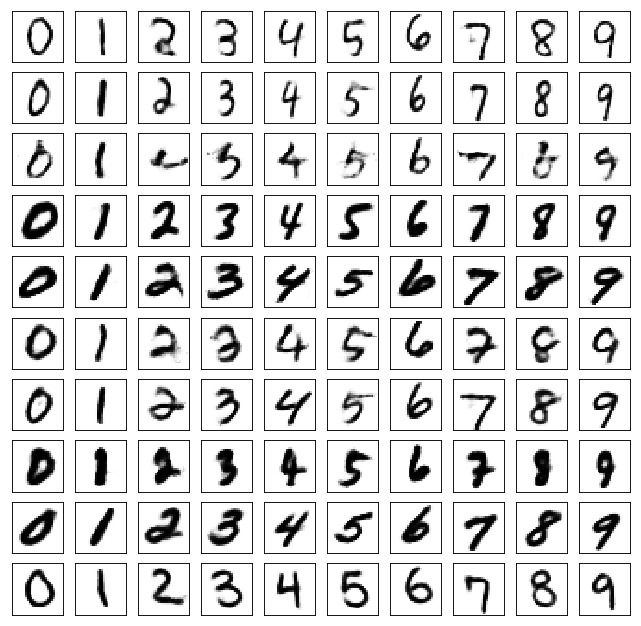

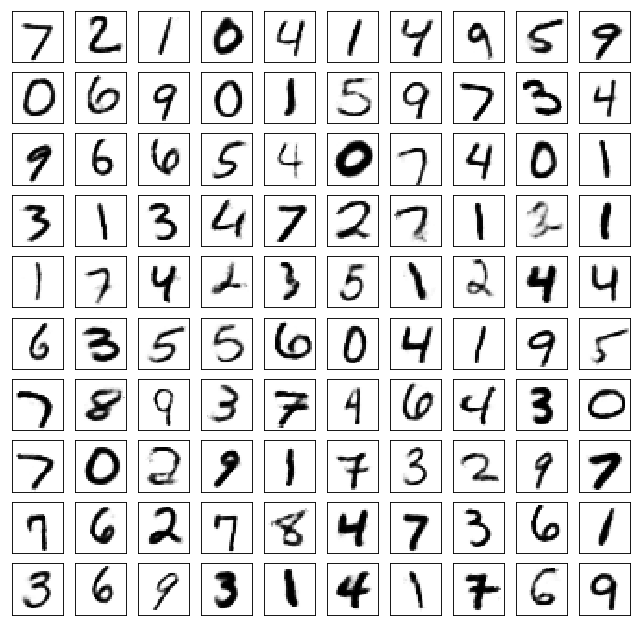

Test losses. E: 0.6911, AE: 0.0499, D: 0.6924
Train Epoch: 701 [0/50000 (0%)]	Losses E: 0.6951, AE: 0.0240, D: 0.6922
Train Epoch: 701 [25000/50000 (50%)]	Losses E: 0.6973, AE: 0.0245, D: 0.6928
Train Epoch: 701 [50000/50000 (100%)]	Losses E: 0.6902, AE: 0.0232, D: 0.6932
Test losses. E: 0.6904, AE: 0.0498, D: 0.6925
Train Epoch: 702 [0/50000 (0%)]	Losses E: 0.6927, AE: 0.0239, D: 0.6939
Train Epoch: 702 [25000/50000 (50%)]	Losses E: 0.6983, AE: 0.0244, D: 0.6943
Train Epoch: 702 [50000/50000 (100%)]	Losses E: 0.6958, AE: 0.0239, D: 0.6916
Test losses. E: 0.6952, AE: 0.0497, D: 0.6921
Train Epoch: 703 [0/50000 (0%)]	Losses E: 0.6952, AE: 0.0260, D: 0.6935
Train Epoch: 703 [25000/50000 (50%)]	Losses E: 0.7017, AE: 0.0236, D: 0.6913
Train Epoch: 703 [50000/50000 (100%)]	Losses E: 0.6932, AE: 0.0278, D: 0.6937
Test losses. E: 0.6942, AE: 0.0498, D: 0.6924
Train Epoch: 704 [0/50000 (0%)]	Losses E: 0.6972, AE: 0.0239, D: 0.6924
Train Epoch: 704 [25000/50000 (50%)]	Losses E: 0.6996, AE: 0.02

Train Epoch: 731 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0245, D: 0.6931
Train Epoch: 731 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.0251, D: 0.6925
Test losses. E: 0.6952, AE: 0.0502, D: 0.6927
Train Epoch: 732 [0/50000 (0%)]	Losses E: 0.6952, AE: 0.0247, D: 0.6951
Train Epoch: 732 [25000/50000 (50%)]	Losses E: 0.7026, AE: 0.0255, D: 0.6939
Train Epoch: 732 [50000/50000 (100%)]	Losses E: 0.6986, AE: 0.0241, D: 0.6923
Test losses. E: 0.6955, AE: 0.0499, D: 0.6920
Train Epoch: 733 [0/50000 (0%)]	Losses E: 0.6946, AE: 0.0237, D: 0.6929
Train Epoch: 733 [25000/50000 (50%)]	Losses E: 0.6940, AE: 0.0245, D: 0.6933
Train Epoch: 733 [50000/50000 (100%)]	Losses E: 0.6957, AE: 0.0250, D: 0.6935
Test losses. E: 0.6969, AE: 0.0500, D: 0.6922
Train Epoch: 734 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0243, D: 0.6945
Train Epoch: 734 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.0237, D: 0.6927
Train Epoch: 734 [50000/50000 (100%)]	Losses E: 0.6895, AE: 0.0251, D: 0.6943
Test losses. E: 0.6940, AE

Train Epoch: 761 [50000/50000 (100%)]	Losses E: 0.6908, AE: 0.0248, D: 0.6927
Test losses. E: 0.6900, AE: 0.0502, D: 0.6920
Train Epoch: 762 [0/50000 (0%)]	Losses E: 0.6883, AE: 0.0240, D: 0.6945
Train Epoch: 762 [25000/50000 (50%)]	Losses E: 0.6895, AE: 0.0253, D: 0.6931
Train Epoch: 762 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0249, D: 0.6944
Test losses. E: 0.6946, AE: 0.0506, D: 0.6926
Train Epoch: 763 [0/50000 (0%)]	Losses E: 0.6962, AE: 0.0249, D: 0.6932
Train Epoch: 763 [25000/50000 (50%)]	Losses E: 0.6910, AE: 0.0264, D: 0.6942
Train Epoch: 763 [50000/50000 (100%)]	Losses E: 0.6922, AE: 0.0261, D: 0.6933
Test losses. E: 0.6914, AE: 0.0505, D: 0.6921
Train Epoch: 764 [0/50000 (0%)]	Losses E: 0.6891, AE: 0.0252, D: 0.6954
Train Epoch: 764 [25000/50000 (50%)]	Losses E: 0.6960, AE: 0.0236, D: 0.6916
Train Epoch: 764 [50000/50000 (100%)]	Losses E: 0.6982, AE: 0.0235, D: 0.6926
Test losses. E: 0.6962, AE: 0.0499, D: 0.6921
Train Epoch: 765 [0/50000 (0%)]	Losses E: 0.6970, AE: 0.0

Test losses. E: 0.6863, AE: 0.0508, D: 0.6926
Train Epoch: 792 [0/50000 (0%)]	Losses E: 0.6866, AE: 0.0242, D: 0.6955
Train Epoch: 792 [25000/50000 (50%)]	Losses E: 0.6886, AE: 0.0226, D: 0.6920
Train Epoch: 792 [50000/50000 (100%)]	Losses E: 0.6910, AE: 0.0236, D: 0.6929
Test losses. E: 0.6874, AE: 0.0508, D: 0.6923
Train Epoch: 793 [0/50000 (0%)]	Losses E: 0.6864, AE: 0.0247, D: 0.6945
Train Epoch: 793 [25000/50000 (50%)]	Losses E: 0.7006, AE: 0.0240, D: 0.6911
Train Epoch: 793 [50000/50000 (100%)]	Losses E: 0.6990, AE: 0.0235, D: 0.6918
Test losses. E: 0.6967, AE: 0.0507, D: 0.6925
Train Epoch: 794 [0/50000 (0%)]	Losses E: 0.7022, AE: 0.0237, D: 0.6890
Train Epoch: 794 [25000/50000 (50%)]	Losses E: 0.6984, AE: 0.0243, D: 0.6906
Train Epoch: 794 [50000/50000 (100%)]	Losses E: 0.6905, AE: 0.0231, D: 0.6929
Test losses. E: 0.6906, AE: 0.0505, D: 0.6919
Train Epoch: 795 [0/50000 (0%)]	Losses E: 0.6914, AE: 0.0218, D: 0.6932
Train Epoch: 795 [25000/50000 (50%)]	Losses E: 0.7000, AE: 0.02

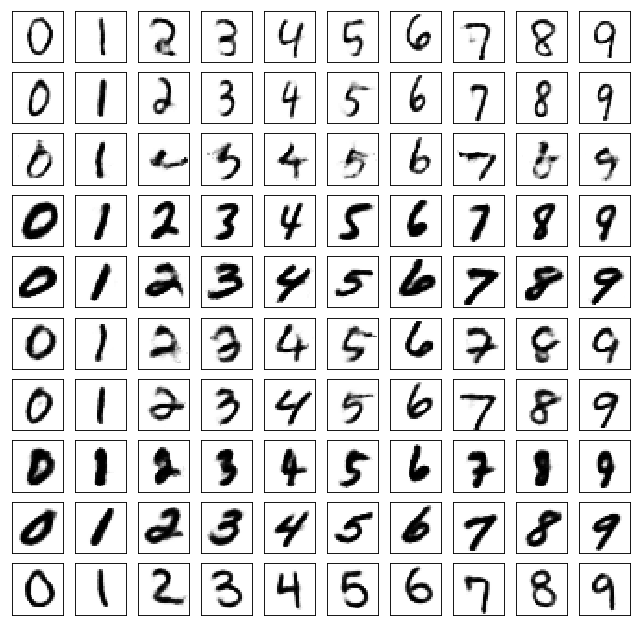

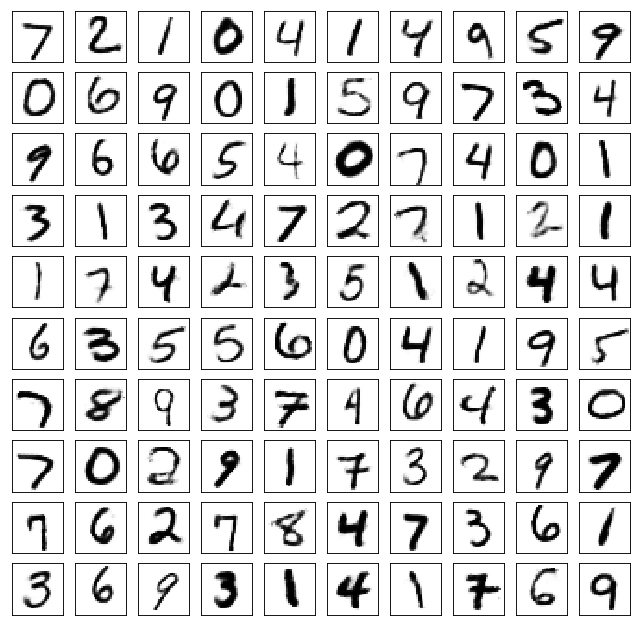

Test losses. E: 0.6857, AE: 0.0504, D: 0.6923
Train Epoch: 801 [0/50000 (0%)]	Losses E: 0.6872, AE: 0.0228, D: 0.6933
Train Epoch: 801 [25000/50000 (50%)]	Losses E: 0.6968, AE: 0.0233, D: 0.6913
Train Epoch: 801 [50000/50000 (100%)]	Losses E: 0.7066, AE: 0.0246, D: 0.6926
Test losses. E: 0.7074, AE: 0.0508, D: 0.6924
Train Epoch: 802 [0/50000 (0%)]	Losses E: 0.7080, AE: 0.0244, D: 0.6954
Train Epoch: 802 [25000/50000 (50%)]	Losses E: 0.6794, AE: 0.0236, D: 0.6908
Train Epoch: 802 [50000/50000 (100%)]	Losses E: 0.7000, AE: 0.0252, D: 0.6953
Test losses. E: 0.6965, AE: 0.0512, D: 0.6928
Train Epoch: 803 [0/50000 (0%)]	Losses E: 0.6966, AE: 0.0239, D: 0.6933
Train Epoch: 803 [25000/50000 (50%)]	Losses E: 0.6994, AE: 0.0238, D: 0.6937
Train Epoch: 803 [50000/50000 (100%)]	Losses E: 0.6833, AE: 0.0231, D: 0.6911
Test losses. E: 0.6841, AE: 0.0506, D: 0.6922
Train Epoch: 804 [0/50000 (0%)]	Losses E: 0.6858, AE: 0.0240, D: 0.6921
Train Epoch: 804 [25000/50000 (50%)]	Losses E: 0.7031, AE: 0.02

Train Epoch: 831 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0212, D: 0.6930
Train Epoch: 831 [50000/50000 (100%)]	Losses E: 0.6932, AE: 0.0227, D: 0.6923
Test losses. E: 0.6942, AE: 0.0508, D: 0.6922
Train Epoch: 832 [0/50000 (0%)]	Losses E: 0.6930, AE: 0.0239, D: 0.6950
Train Epoch: 832 [25000/50000 (50%)]	Losses E: 0.6997, AE: 0.0234, D: 0.6916
Train Epoch: 832 [50000/50000 (100%)]	Losses E: 0.6933, AE: 0.0223, D: 0.6911
Test losses. E: 0.6919, AE: 0.0507, D: 0.6922
Train Epoch: 833 [0/50000 (0%)]	Losses E: 0.6905, AE: 0.0219, D: 0.6938
Train Epoch: 833 [25000/50000 (50%)]	Losses E: 0.6895, AE: 0.0232, D: 0.6919
Train Epoch: 833 [50000/50000 (100%)]	Losses E: 0.6871, AE: 0.0248, D: 0.6916
Test losses. E: 0.6919, AE: 0.0510, D: 0.6926
Train Epoch: 834 [0/50000 (0%)]	Losses E: 0.6907, AE: 0.0242, D: 0.6945
Train Epoch: 834 [25000/50000 (50%)]	Losses E: 0.7022, AE: 0.0231, D: 0.6932
Train Epoch: 834 [50000/50000 (100%)]	Losses E: 0.6929, AE: 0.0229, D: 0.6938
Test losses. E: 0.6928, AE

Train Epoch: 861 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0232, D: 0.6938
Test losses. E: 0.6937, AE: 0.0510, D: 0.6920
Train Epoch: 862 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0218, D: 0.6955
Train Epoch: 862 [25000/50000 (50%)]	Losses E: 0.6935, AE: 0.0229, D: 0.6927
Train Epoch: 862 [50000/50000 (100%)]	Losses E: 0.7035, AE: 0.0225, D: 0.6903
Test losses. E: 0.6996, AE: 0.0510, D: 0.6923
Train Epoch: 863 [0/50000 (0%)]	Losses E: 0.6984, AE: 0.0232, D: 0.6927
Train Epoch: 863 [25000/50000 (50%)]	Losses E: 0.6956, AE: 0.0244, D: 0.6957
Train Epoch: 863 [50000/50000 (100%)]	Losses E: 0.6970, AE: 0.0217, D: 0.6931
Test losses. E: 0.6969, AE: 0.0510, D: 0.6923
Train Epoch: 864 [0/50000 (0%)]	Losses E: 0.7014, AE: 0.0208, D: 0.6929
Train Epoch: 864 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0241, D: 0.6929
Train Epoch: 864 [50000/50000 (100%)]	Losses E: 0.6963, AE: 0.0219, D: 0.6916
Test losses. E: 0.6916, AE: 0.0511, D: 0.6923
Train Epoch: 865 [0/50000 (0%)]	Losses E: 0.6937, AE: 0.0

Test losses. E: 0.6894, AE: 0.0513, D: 0.6923
Train Epoch: 892 [0/50000 (0%)]	Losses E: 0.6916, AE: 0.0214, D: 0.6927
Train Epoch: 892 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0222, D: 0.6924
Train Epoch: 892 [50000/50000 (100%)]	Losses E: 0.6949, AE: 0.0228, D: 0.6901
Test losses. E: 0.6932, AE: 0.0516, D: 0.6926
Train Epoch: 893 [0/50000 (0%)]	Losses E: 0.6958, AE: 0.0230, D: 0.6927
Train Epoch: 893 [25000/50000 (50%)]	Losses E: 0.6984, AE: 0.0227, D: 0.6942
Train Epoch: 893 [50000/50000 (100%)]	Losses E: 0.6893, AE: 0.0213, D: 0.6937
Test losses. E: 0.6894, AE: 0.0515, D: 0.6923
Train Epoch: 894 [0/50000 (0%)]	Losses E: 0.6900, AE: 0.0224, D: 0.6919
Train Epoch: 894 [25000/50000 (50%)]	Losses E: 0.6885, AE: 0.0223, D: 0.6923
Train Epoch: 894 [50000/50000 (100%)]	Losses E: 0.6948, AE: 0.0228, D: 0.6954
Test losses. E: 0.6960, AE: 0.0515, D: 0.6922
Train Epoch: 895 [0/50000 (0%)]	Losses E: 0.7001, AE: 0.0211, D: 0.6915
Train Epoch: 895 [25000/50000 (50%)]	Losses E: 0.7094, AE: 0.02

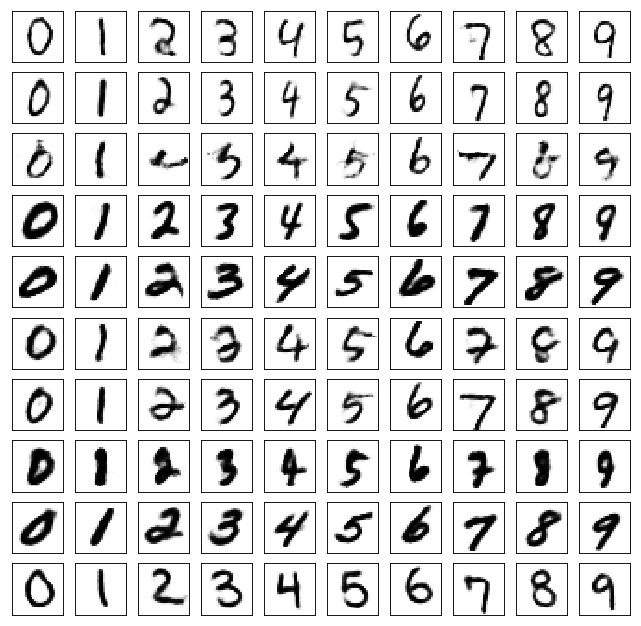

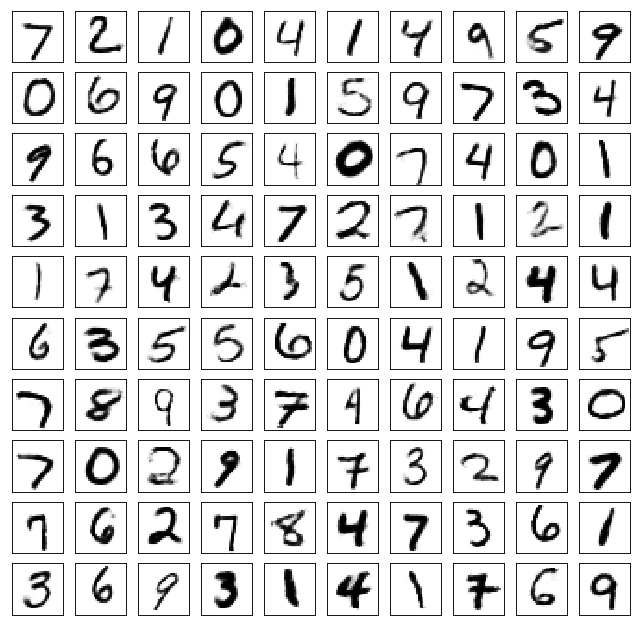

Test losses. E: 0.6956, AE: 0.0514, D: 0.6924
Train Epoch: 901 [0/50000 (0%)]	Losses E: 0.6986, AE: 0.0215, D: 0.6936
Train Epoch: 901 [25000/50000 (50%)]	Losses E: 0.6932, AE: 0.0234, D: 0.6936
Train Epoch: 901 [50000/50000 (100%)]	Losses E: 0.6915, AE: 0.0222, D: 0.6945
Test losses. E: 0.6952, AE: 0.0516, D: 0.6925
Train Epoch: 902 [0/50000 (0%)]	Losses E: 0.6976, AE: 0.0223, D: 0.6929
Train Epoch: 902 [25000/50000 (50%)]	Losses E: 0.6987, AE: 0.0219, D: 0.6933
Train Epoch: 902 [50000/50000 (100%)]	Losses E: 0.6860, AE: 0.0231, D: 0.6912
Test losses. E: 0.6865, AE: 0.0512, D: 0.6923
Train Epoch: 903 [0/50000 (0%)]	Losses E: 0.6888, AE: 0.0216, D: 0.6933
Train Epoch: 903 [25000/50000 (50%)]	Losses E: 0.7007, AE: 0.0239, D: 0.6918
Train Epoch: 903 [50000/50000 (100%)]	Losses E: 0.6933, AE: 0.0213, D: 0.6938
Test losses. E: 0.6923, AE: 0.0513, D: 0.6925
Train Epoch: 904 [0/50000 (0%)]	Losses E: 0.6932, AE: 0.0233, D: 0.6927
Train Epoch: 904 [25000/50000 (50%)]	Losses E: 0.7007, AE: 0.02

Train Epoch: 931 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0222, D: 0.6928
Train Epoch: 931 [50000/50000 (100%)]	Losses E: 0.7051, AE: 0.0229, D: 0.6920
Test losses. E: 0.7007, AE: 0.0519, D: 0.6923
Train Epoch: 932 [0/50000 (0%)]	Losses E: 0.7008, AE: 0.0219, D: 0.6934
Train Epoch: 932 [25000/50000 (50%)]	Losses E: 0.6867, AE: 0.0231, D: 0.6941
Train Epoch: 932 [50000/50000 (100%)]	Losses E: 0.6925, AE: 0.0214, D: 0.6904
Test losses. E: 0.6897, AE: 0.0514, D: 0.6920
Train Epoch: 933 [0/50000 (0%)]	Losses E: 0.6869, AE: 0.0229, D: 0.6931
Train Epoch: 933 [25000/50000 (50%)]	Losses E: 0.6981, AE: 0.0224, D: 0.6940
Train Epoch: 933 [50000/50000 (100%)]	Losses E: 0.7029, AE: 0.0216, D: 0.6890
Test losses. E: 0.6973, AE: 0.0516, D: 0.6921
Train Epoch: 934 [0/50000 (0%)]	Losses E: 0.6989, AE: 0.0222, D: 0.6923
Train Epoch: 934 [25000/50000 (50%)]	Losses E: 0.6894, AE: 0.0223, D: 0.6942
Train Epoch: 934 [50000/50000 (100%)]	Losses E: 0.6948, AE: 0.0217, D: 0.6950
Test losses. E: 0.6942, AE

Train Epoch: 961 [50000/50000 (100%)]	Losses E: 0.6923, AE: 0.0229, D: 0.6921
Test losses. E: 0.6932, AE: 0.0519, D: 0.6924
Train Epoch: 962 [0/50000 (0%)]	Losses E: 0.6990, AE: 0.0211, D: 0.6922
Train Epoch: 962 [25000/50000 (50%)]	Losses E: 0.7008, AE: 0.0221, D: 0.6928
Train Epoch: 962 [50000/50000 (100%)]	Losses E: 0.6994, AE: 0.0224, D: 0.6948
Test losses. E: 0.7011, AE: 0.0521, D: 0.6920
Train Epoch: 963 [0/50000 (0%)]	Losses E: 0.6997, AE: 0.0216, D: 0.6936
Train Epoch: 963 [25000/50000 (50%)]	Losses E: 0.6907, AE: 0.0221, D: 0.6914
Train Epoch: 963 [50000/50000 (100%)]	Losses E: 0.6929, AE: 0.0217, D: 0.6933
Test losses. E: 0.6906, AE: 0.0520, D: 0.6923
Train Epoch: 964 [0/50000 (0%)]	Losses E: 0.6895, AE: 0.0229, D: 0.6925
Train Epoch: 964 [25000/50000 (50%)]	Losses E: 0.6869, AE: 0.0223, D: 0.6960
Train Epoch: 964 [50000/50000 (100%)]	Losses E: 0.6995, AE: 0.0206, D: 0.6928
Test losses. E: 0.6964, AE: 0.0519, D: 0.6923
Train Epoch: 965 [0/50000 (0%)]	Losses E: 0.6976, AE: 0.0

Test losses. E: 0.6883, AE: 0.0523, D: 0.6926
Train Epoch: 992 [0/50000 (0%)]	Losses E: 0.6864, AE: 0.0223, D: 0.6925
Train Epoch: 992 [25000/50000 (50%)]	Losses E: 0.6911, AE: 0.0229, D: 0.6917
Train Epoch: 992 [50000/50000 (100%)]	Losses E: 0.6976, AE: 0.0214, D: 0.6922
Test losses. E: 0.6936, AE: 0.0524, D: 0.6923
Train Epoch: 993 [0/50000 (0%)]	Losses E: 0.7002, AE: 0.0217, D: 0.6933
Train Epoch: 993 [25000/50000 (50%)]	Losses E: 0.6984, AE: 0.0215, D: 0.6909
Train Epoch: 993 [50000/50000 (100%)]	Losses E: 0.6933, AE: 0.0219, D: 0.6929
Test losses. E: 0.6918, AE: 0.0522, D: 0.6925
Train Epoch: 994 [0/50000 (0%)]	Losses E: 0.6936, AE: 0.0210, D: 0.6918
Train Epoch: 994 [25000/50000 (50%)]	Losses E: 0.6889, AE: 0.0231, D: 0.6924
Train Epoch: 994 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0220, D: 0.6927
Test losses. E: 0.6930, AE: 0.0524, D: 0.6920
Train Epoch: 995 [0/50000 (0%)]	Losses E: 0.6975, AE: 0.0220, D: 0.6929
Train Epoch: 995 [25000/50000 (50%)]	Losses E: 0.6898, AE: 0.02

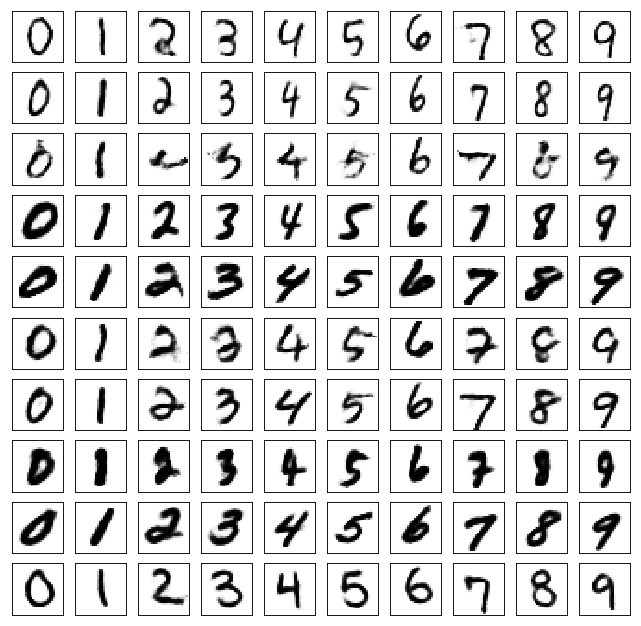

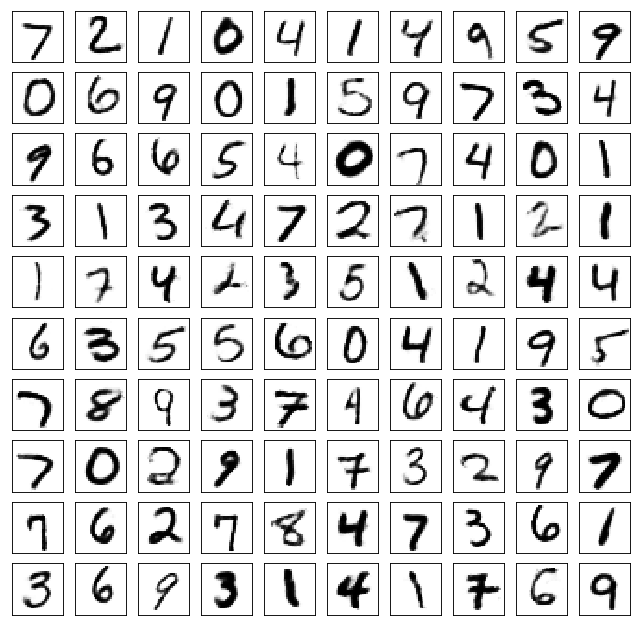

Test losses. E: 0.6905, AE: 0.0524, D: 0.6928


In [14]:
for epoch in range(1, 1001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [15]:
for param_group in Enc_optimizer.param_groups:
    param_group['lr'] *= 0.1
for param_group in Dec_optimizer.param_groups:
    param_group['lr'] *= 0.1
for param_group in Disc_optimizer.param_groups:
    param_group['lr'] *= 0.1

Train Epoch: 1001 [0/50000 (0%)]	Losses E: 0.6910, AE: 0.0209, D: 0.6924
Train Epoch: 1001 [25000/50000 (50%)]	Losses E: 0.6954, AE: 0.0198, D: 0.6932
Train Epoch: 1001 [50000/50000 (100%)]	Losses E: 0.6901, AE: 0.0213, D: 0.6943
Test losses. E: 0.6933, AE: 0.0512, D: 0.6920
Train Epoch: 1002 [0/50000 (0%)]	Losses E: 0.6906, AE: 0.0200, D: 0.6937
Train Epoch: 1002 [25000/50000 (50%)]	Losses E: 0.6927, AE: 0.0194, D: 0.6950
Train Epoch: 1002 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0213, D: 0.6948
Test losses. E: 0.6938, AE: 0.0512, D: 0.6917
Train Epoch: 1003 [0/50000 (0%)]	Losses E: 0.7004, AE: 0.0196, D: 0.6937
Train Epoch: 1003 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0195, D: 0.6929
Train Epoch: 1003 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0195, D: 0.6898
Test losses. E: 0.6935, AE: 0.0513, D: 0.6921
Train Epoch: 1004 [0/50000 (0%)]	Losses E: 0.6977, AE: 0.0190, D: 0.6919
Train Epoch: 1004 [25000/50000 (50%)]	Losses E: 0.6993, AE: 0.0194, D: 0.6910
Train Epoch: 1004 [50

Test losses. E: 0.6938, AE: 0.0516, D: 0.6921
Train Epoch: 1031 [0/50000 (0%)]	Losses E: 0.6925, AE: 0.0203, D: 0.6933
Train Epoch: 1031 [25000/50000 (50%)]	Losses E: 0.6915, AE: 0.0216, D: 0.6936
Train Epoch: 1031 [50000/50000 (100%)]	Losses E: 0.6951, AE: 0.0194, D: 0.6932
Test losses. E: 0.6939, AE: 0.0516, D: 0.6921
Train Epoch: 1032 [0/50000 (0%)]	Losses E: 0.6988, AE: 0.0197, D: 0.6885
Train Epoch: 1032 [25000/50000 (50%)]	Losses E: 0.6940, AE: 0.0203, D: 0.6920
Train Epoch: 1032 [50000/50000 (100%)]	Losses E: 0.6920, AE: 0.0198, D: 0.6935
Test losses. E: 0.6936, AE: 0.0516, D: 0.6920
Train Epoch: 1033 [0/50000 (0%)]	Losses E: 0.6995, AE: 0.0199, D: 0.6911
Train Epoch: 1033 [25000/50000 (50%)]	Losses E: 0.6926, AE: 0.0199, D: 0.6927
Train Epoch: 1033 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0194, D: 0.6945
Test losses. E: 0.6930, AE: 0.0516, D: 0.6920
Train Epoch: 1034 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0201, D: 0.6929
Train Epoch: 1034 [25000/50000 (50%)]	Losses E: 0.695

Train Epoch: 1060 [50000/50000 (100%)]	Losses E: 0.6914, AE: 0.0193, D: 0.6926
Test losses. E: 0.6941, AE: 0.0518, D: 0.6919
Train Epoch: 1061 [0/50000 (0%)]	Losses E: 0.6981, AE: 0.0188, D: 0.6906
Train Epoch: 1061 [25000/50000 (50%)]	Losses E: 0.6919, AE: 0.0195, D: 0.6931
Train Epoch: 1061 [50000/50000 (100%)]	Losses E: 0.7005, AE: 0.0199, D: 0.6943
Test losses. E: 0.6934, AE: 0.0518, D: 0.6917
Train Epoch: 1062 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0196, D: 0.6943
Train Epoch: 1062 [25000/50000 (50%)]	Losses E: 0.7011, AE: 0.0198, D: 0.6900
Train Epoch: 1062 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0192, D: 0.6896
Test losses. E: 0.6938, AE: 0.0518, D: 0.6921
Train Epoch: 1063 [0/50000 (0%)]	Losses E: 0.6946, AE: 0.0202, D: 0.6972
Train Epoch: 1063 [25000/50000 (50%)]	Losses E: 0.6960, AE: 0.0195, D: 0.6944
Train Epoch: 1063 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0192, D: 0.6904
Test losses. E: 0.6934, AE: 0.0518, D: 0.6920
Train Epoch: 1064 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1090 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0189, D: 0.6918
Train Epoch: 1090 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0198, D: 0.6933
Test losses. E: 0.6940, AE: 0.0520, D: 0.6920
Train Epoch: 1091 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0205, D: 0.6910
Train Epoch: 1091 [25000/50000 (50%)]	Losses E: 0.6990, AE: 0.0195, D: 0.6925
Train Epoch: 1091 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0185, D: 0.6927
Test losses. E: 0.6937, AE: 0.0520, D: 0.6922
Train Epoch: 1092 [0/50000 (0%)]	Losses E: 0.6939, AE: 0.0201, D: 0.6885
Train Epoch: 1092 [25000/50000 (50%)]	Losses E: 0.7022, AE: 0.0191, D: 0.6878
Train Epoch: 1092 [50000/50000 (100%)]	Losses E: 0.6917, AE: 0.0198, D: 0.6910
Test losses. E: 0.6932, AE: 0.0520, D: 0.6920
Train Epoch: 1093 [0/50000 (0%)]	Losses E: 0.6942, AE: 0.0192, D: 0.6933
Train Epoch: 1093 [25000/50000 (50%)]	Losses E: 0.6952, AE: 0.0180, D: 0.6902
Train Epoch: 1093 [50000/50000 (100%)]	Losses E: 0.6989, AE: 0.0183, D: 0.6917
Test losses. E:

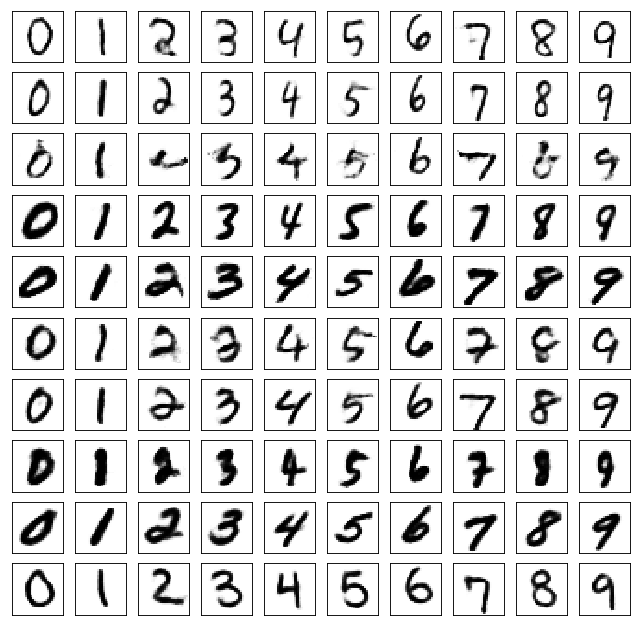

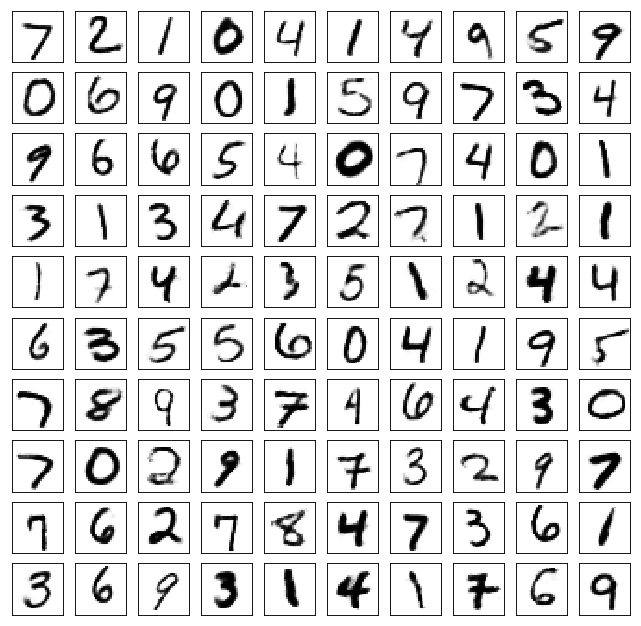

Test losses. E: 0.6938, AE: 0.0521, D: 0.6921
Train Epoch: 1101 [0/50000 (0%)]	Losses E: 0.6961, AE: 0.0187, D: 0.6921
Train Epoch: 1101 [25000/50000 (50%)]	Losses E: 0.6960, AE: 0.0200, D: 0.6927
Train Epoch: 1101 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0182, D: 0.6927
Test losses. E: 0.6933, AE: 0.0521, D: 0.6921
Train Epoch: 1102 [0/50000 (0%)]	Losses E: 0.6916, AE: 0.0197, D: 0.6925
Train Epoch: 1102 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0191, D: 0.6926
Train Epoch: 1102 [50000/50000 (100%)]	Losses E: 0.6954, AE: 0.0192, D: 0.6900
Test losses. E: 0.6939, AE: 0.0521, D: 0.6922
Train Epoch: 1103 [0/50000 (0%)]	Losses E: 0.6934, AE: 0.0203, D: 0.6941
Train Epoch: 1103 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0188, D: 0.6919
Train Epoch: 1103 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0189, D: 0.6925
Test losses. E: 0.6933, AE: 0.0521, D: 0.6920
Train Epoch: 1104 [0/50000 (0%)]	Losses E: 0.6971, AE: 0.0203, D: 0.6916
Train Epoch: 1104 [25000/50000 (50%)]	Losses E: 0.695

Train Epoch: 1130 [50000/50000 (100%)]	Losses E: 0.6954, AE: 0.0209, D: 0.6947
Test losses. E: 0.6934, AE: 0.0523, D: 0.6921
Train Epoch: 1131 [0/50000 (0%)]	Losses E: 0.6973, AE: 0.0197, D: 0.6915
Train Epoch: 1131 [25000/50000 (50%)]	Losses E: 0.6977, AE: 0.0184, D: 0.6935
Train Epoch: 1131 [50000/50000 (100%)]	Losses E: 0.6964, AE: 0.0192, D: 0.6929
Test losses. E: 0.6941, AE: 0.0522, D: 0.6922
Train Epoch: 1132 [0/50000 (0%)]	Losses E: 0.6954, AE: 0.0197, D: 0.6935
Train Epoch: 1132 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0196, D: 0.6934
Train Epoch: 1132 [50000/50000 (100%)]	Losses E: 0.6956, AE: 0.0191, D: 0.6937
Test losses. E: 0.6934, AE: 0.0522, D: 0.6917
Train Epoch: 1133 [0/50000 (0%)]	Losses E: 0.6931, AE: 0.0189, D: 0.6922
Train Epoch: 1133 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0209, D: 0.6915
Train Epoch: 1133 [50000/50000 (100%)]	Losses E: 0.6990, AE: 0.0192, D: 0.6939
Test losses. E: 0.6933, AE: 0.0522, D: 0.6922
Train Epoch: 1134 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1160 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0205, D: 0.6903
Train Epoch: 1160 [50000/50000 (100%)]	Losses E: 0.6921, AE: 0.0193, D: 0.6967
Test losses. E: 0.6936, AE: 0.0524, D: 0.6920
Train Epoch: 1161 [0/50000 (0%)]	Losses E: 0.6923, AE: 0.0193, D: 0.6956
Train Epoch: 1161 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0203, D: 0.6929
Train Epoch: 1161 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0197, D: 0.6931
Test losses. E: 0.6940, AE: 0.0524, D: 0.6920
Train Epoch: 1162 [0/50000 (0%)]	Losses E: 0.6962, AE: 0.0192, D: 0.6961
Train Epoch: 1162 [25000/50000 (50%)]	Losses E: 0.6986, AE: 0.0198, D: 0.6905
Train Epoch: 1162 [50000/50000 (100%)]	Losses E: 0.6998, AE: 0.0193, D: 0.6900
Test losses. E: 0.6939, AE: 0.0524, D: 0.6920
Train Epoch: 1163 [0/50000 (0%)]	Losses E: 0.6935, AE: 0.0210, D: 0.6961
Train Epoch: 1163 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0195, D: 0.6914
Train Epoch: 1163 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0191, D: 0.6930
Test losses. E:

Train Epoch: 1190 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0194, D: 0.6927
Train Epoch: 1190 [50000/50000 (100%)]	Losses E: 0.6976, AE: 0.0184, D: 0.6933
Test losses. E: 0.6932, AE: 0.0525, D: 0.6923
Train Epoch: 1191 [0/50000 (0%)]	Losses E: 0.6945, AE: 0.0180, D: 0.6920
Train Epoch: 1191 [25000/50000 (50%)]	Losses E: 0.6972, AE: 0.0182, D: 0.6918
Train Epoch: 1191 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0197, D: 0.6936
Test losses. E: 0.6940, AE: 0.0524, D: 0.6918
Train Epoch: 1192 [0/50000 (0%)]	Losses E: 0.6934, AE: 0.0194, D: 0.6942
Train Epoch: 1192 [25000/50000 (50%)]	Losses E: 0.6978, AE: 0.0191, D: 0.6925
Train Epoch: 1192 [50000/50000 (100%)]	Losses E: 0.6972, AE: 0.0189, D: 0.6921
Test losses. E: 0.6933, AE: 0.0525, D: 0.6920
Train Epoch: 1193 [0/50000 (0%)]	Losses E: 0.6978, AE: 0.0178, D: 0.6893
Train Epoch: 1193 [25000/50000 (50%)]	Losses E: 0.6965, AE: 0.0195, D: 0.6960
Train Epoch: 1193 [50000/50000 (100%)]	Losses E: 0.6929, AE: 0.0199, D: 0.6952
Test losses. E:

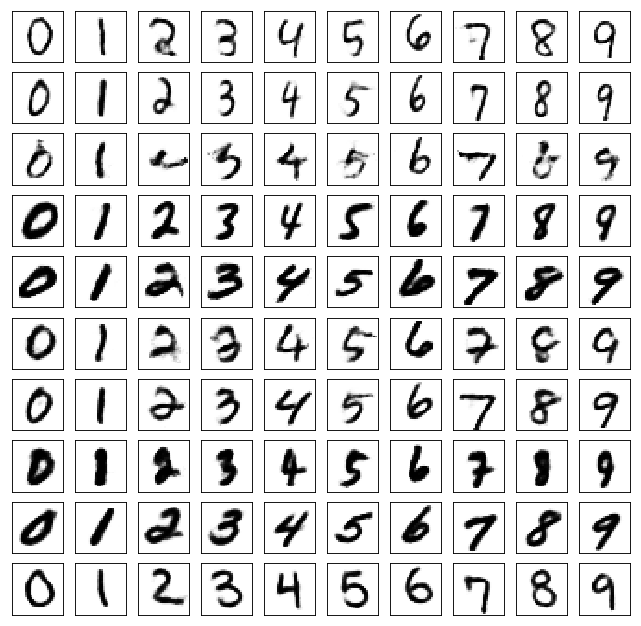

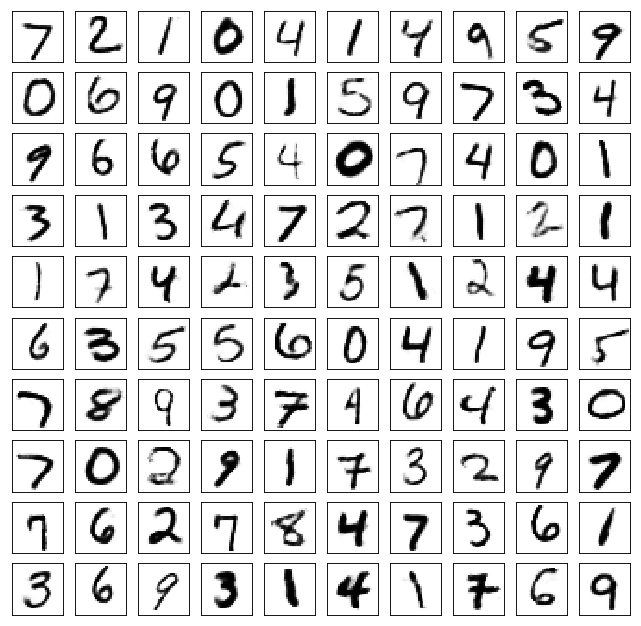

Test losses. E: 0.6934, AE: 0.0525, D: 0.6922
Train Epoch: 1201 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0202, D: 0.6926
Train Epoch: 1201 [25000/50000 (50%)]	Losses E: 0.6966, AE: 0.0195, D: 0.6914
Train Epoch: 1201 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0193, D: 0.6917
Test losses. E: 0.6930, AE: 0.0525, D: 0.6920
Train Epoch: 1202 [0/50000 (0%)]	Losses E: 0.6953, AE: 0.0201, D: 0.6909
Train Epoch: 1202 [25000/50000 (50%)]	Losses E: 0.6939, AE: 0.0191, D: 0.6925
Train Epoch: 1202 [50000/50000 (100%)]	Losses E: 0.6910, AE: 0.0203, D: 0.6941
Test losses. E: 0.6936, AE: 0.0526, D: 0.6921
Train Epoch: 1203 [0/50000 (0%)]	Losses E: 0.6958, AE: 0.0188, D: 0.6933
Train Epoch: 1203 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0187, D: 0.6907
Train Epoch: 1203 [50000/50000 (100%)]	Losses E: 0.6969, AE: 0.0180, D: 0.6914
Test losses. E: 0.6939, AE: 0.0525, D: 0.6919
Train Epoch: 1204 [0/50000 (0%)]	Losses E: 0.6958, AE: 0.0192, D: 0.6926
Train Epoch: 1204 [25000/50000 (50%)]	Losses E: 0.693

Train Epoch: 1230 [50000/50000 (100%)]	Losses E: 0.6916, AE: 0.0200, D: 0.6930
Test losses. E: 0.6939, AE: 0.0526, D: 0.6920
Train Epoch: 1231 [0/50000 (0%)]	Losses E: 0.6903, AE: 0.0197, D: 0.6943
Train Epoch: 1231 [25000/50000 (50%)]	Losses E: 0.6984, AE: 0.0191, D: 0.6905
Train Epoch: 1231 [50000/50000 (100%)]	Losses E: 0.6954, AE: 0.0196, D: 0.6891
Test losses. E: 0.6946, AE: 0.0527, D: 0.6920
Train Epoch: 1232 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0193, D: 0.6931
Train Epoch: 1232 [25000/50000 (50%)]	Losses E: 0.6964, AE: 0.0189, D: 0.6951
Train Epoch: 1232 [50000/50000 (100%)]	Losses E: 0.6943, AE: 0.0198, D: 0.6954
Test losses. E: 0.6944, AE: 0.0526, D: 0.6920
Train Epoch: 1233 [0/50000 (0%)]	Losses E: 0.6955, AE: 0.0198, D: 0.6936
Train Epoch: 1233 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0197, D: 0.6948
Train Epoch: 1233 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0206, D: 0.6933
Test losses. E: 0.6931, AE: 0.0526, D: 0.6922
Train Epoch: 1234 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1260 [25000/50000 (50%)]	Losses E: 0.6988, AE: 0.0199, D: 0.6932
Train Epoch: 1260 [50000/50000 (100%)]	Losses E: 0.6969, AE: 0.0189, D: 0.6900
Test losses. E: 0.6939, AE: 0.0527, D: 0.6921
Train Epoch: 1261 [0/50000 (0%)]	Losses E: 0.6962, AE: 0.0191, D: 0.6923
Train Epoch: 1261 [25000/50000 (50%)]	Losses E: 0.6985, AE: 0.0191, D: 0.6926
Train Epoch: 1261 [50000/50000 (100%)]	Losses E: 0.6982, AE: 0.0194, D: 0.6930
Test losses. E: 0.6936, AE: 0.0527, D: 0.6920
Train Epoch: 1262 [0/50000 (0%)]	Losses E: 0.6957, AE: 0.0183, D: 0.6936
Train Epoch: 1262 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0193, D: 0.6916
Train Epoch: 1262 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0201, D: 0.6901
Test losses. E: 0.6943, AE: 0.0528, D: 0.6922
Train Epoch: 1263 [0/50000 (0%)]	Losses E: 0.6926, AE: 0.0197, D: 0.6932
Train Epoch: 1263 [25000/50000 (50%)]	Losses E: 0.6912, AE: 0.0199, D: 0.6913
Train Epoch: 1263 [50000/50000 (100%)]	Losses E: 0.6919, AE: 0.0201, D: 0.6947
Test losses. E:

Train Epoch: 1290 [25000/50000 (50%)]	Losses E: 0.6957, AE: 0.0193, D: 0.6918
Train Epoch: 1290 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0190, D: 0.6954
Test losses. E: 0.6938, AE: 0.0528, D: 0.6921
Train Epoch: 1291 [0/50000 (0%)]	Losses E: 0.6952, AE: 0.0186, D: 0.6929
Train Epoch: 1291 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0199, D: 0.6911
Train Epoch: 1291 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0185, D: 0.6906
Test losses. E: 0.6943, AE: 0.0528, D: 0.6919
Train Epoch: 1292 [0/50000 (0%)]	Losses E: 0.6932, AE: 0.0176, D: 0.6928
Train Epoch: 1292 [25000/50000 (50%)]	Losses E: 0.6984, AE: 0.0196, D: 0.6941
Train Epoch: 1292 [50000/50000 (100%)]	Losses E: 0.6944, AE: 0.0199, D: 0.6949
Test losses. E: 0.6936, AE: 0.0528, D: 0.6920
Train Epoch: 1293 [0/50000 (0%)]	Losses E: 0.6912, AE: 0.0197, D: 0.6936
Train Epoch: 1293 [25000/50000 (50%)]	Losses E: 0.6959, AE: 0.0190, D: 0.6891
Train Epoch: 1293 [50000/50000 (100%)]	Losses E: 0.6958, AE: 0.0183, D: 0.6904
Test losses. E:

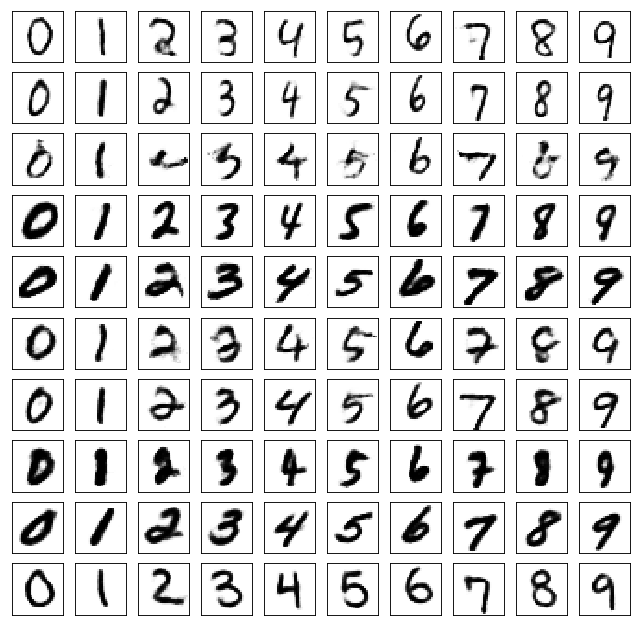

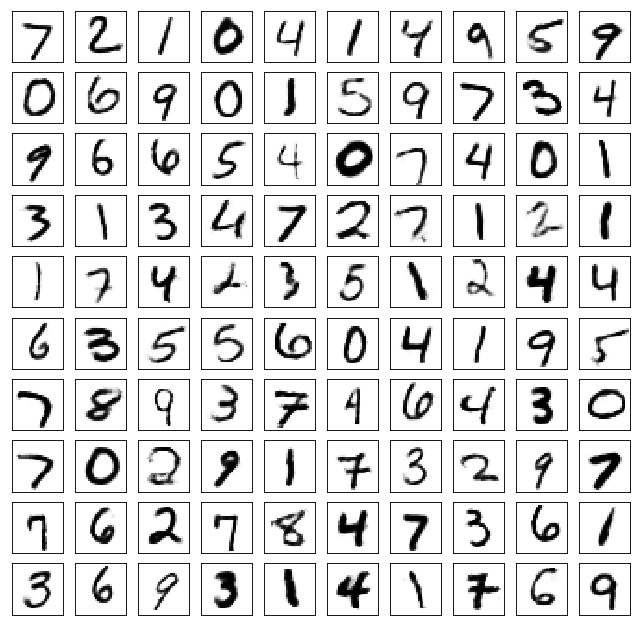

Test losses. E: 0.6943, AE: 0.0529, D: 0.6921
Train Epoch: 1301 [0/50000 (0%)]	Losses E: 0.6974, AE: 0.0190, D: 0.6928
Train Epoch: 1301 [25000/50000 (50%)]	Losses E: 0.7000, AE: 0.0192, D: 0.6921
Train Epoch: 1301 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0191, D: 0.6894
Test losses. E: 0.6937, AE: 0.0529, D: 0.6920
Train Epoch: 1302 [0/50000 (0%)]	Losses E: 0.6951, AE: 0.0180, D: 0.6935
Train Epoch: 1302 [25000/50000 (50%)]	Losses E: 0.7007, AE: 0.0188, D: 0.6936
Train Epoch: 1302 [50000/50000 (100%)]	Losses E: 0.6978, AE: 0.0185, D: 0.6918
Test losses. E: 0.6938, AE: 0.0528, D: 0.6920
Train Epoch: 1303 [0/50000 (0%)]	Losses E: 0.6948, AE: 0.0196, D: 0.6922
Train Epoch: 1303 [25000/50000 (50%)]	Losses E: 0.6940, AE: 0.0201, D: 0.6910
Train Epoch: 1303 [50000/50000 (100%)]	Losses E: 0.6945, AE: 0.0194, D: 0.6946
Test losses. E: 0.6946, AE: 0.0529, D: 0.6920
Train Epoch: 1304 [0/50000 (0%)]	Losses E: 0.6923, AE: 0.0204, D: 0.6932
Train Epoch: 1304 [25000/50000 (50%)]	Losses E: 0.692

Train Epoch: 1330 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0195, D: 0.6930
Test losses. E: 0.6936, AE: 0.0530, D: 0.6922
Train Epoch: 1331 [0/50000 (0%)]	Losses E: 0.6951, AE: 0.0187, D: 0.6912
Train Epoch: 1331 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0190, D: 0.6923
Train Epoch: 1331 [50000/50000 (100%)]	Losses E: 0.6937, AE: 0.0194, D: 0.6915
Test losses. E: 0.6935, AE: 0.0530, D: 0.6921
Train Epoch: 1332 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0195, D: 0.6907
Train Epoch: 1332 [25000/50000 (50%)]	Losses E: 0.7004, AE: 0.0186, D: 0.6902
Train Epoch: 1332 [50000/50000 (100%)]	Losses E: 0.6962, AE: 0.0193, D: 0.6938
Test losses. E: 0.6945, AE: 0.0530, D: 0.6922
Train Epoch: 1333 [0/50000 (0%)]	Losses E: 0.6972, AE: 0.0188, D: 0.6932
Train Epoch: 1333 [25000/50000 (50%)]	Losses E: 0.6975, AE: 0.0200, D: 0.6893
Train Epoch: 1333 [50000/50000 (100%)]	Losses E: 0.6902, AE: 0.0188, D: 0.6938
Test losses. E: 0.6932, AE: 0.0530, D: 0.6919
Train Epoch: 1334 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1360 [25000/50000 (50%)]	Losses E: 0.6975, AE: 0.0197, D: 0.6941
Train Epoch: 1360 [50000/50000 (100%)]	Losses E: 0.6946, AE: 0.0186, D: 0.6930
Test losses. E: 0.6937, AE: 0.0530, D: 0.6920
Train Epoch: 1361 [0/50000 (0%)]	Losses E: 0.6952, AE: 0.0192, D: 0.6903
Train Epoch: 1361 [25000/50000 (50%)]	Losses E: 0.6967, AE: 0.0193, D: 0.6934
Train Epoch: 1361 [50000/50000 (100%)]	Losses E: 0.6941, AE: 0.0187, D: 0.6934
Test losses. E: 0.6931, AE: 0.0530, D: 0.6920
Train Epoch: 1362 [0/50000 (0%)]	Losses E: 0.6934, AE: 0.0193, D: 0.6934
Train Epoch: 1362 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0214, D: 0.6913
Train Epoch: 1362 [50000/50000 (100%)]	Losses E: 0.6919, AE: 0.0198, D: 0.6943
Test losses. E: 0.6936, AE: 0.0531, D: 0.6922
Train Epoch: 1363 [0/50000 (0%)]	Losses E: 0.6930, AE: 0.0188, D: 0.6919
Train Epoch: 1363 [25000/50000 (50%)]	Losses E: 0.6955, AE: 0.0190, D: 0.6918
Train Epoch: 1363 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0197, D: 0.6905
Test losses. E:

Train Epoch: 1390 [25000/50000 (50%)]	Losses E: 0.6954, AE: 0.0195, D: 0.6904
Train Epoch: 1390 [50000/50000 (100%)]	Losses E: 0.6938, AE: 0.0197, D: 0.6933
Test losses. E: 0.6938, AE: 0.0532, D: 0.6918
Train Epoch: 1391 [0/50000 (0%)]	Losses E: 0.6989, AE: 0.0184, D: 0.6899
Train Epoch: 1391 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0183, D: 0.6945
Train Epoch: 1391 [50000/50000 (100%)]	Losses E: 0.6981, AE: 0.0186, D: 0.6943
Test losses. E: 0.6943, AE: 0.0531, D: 0.6920
Train Epoch: 1392 [0/50000 (0%)]	Losses E: 0.6959, AE: 0.0185, D: 0.6958
Train Epoch: 1392 [25000/50000 (50%)]	Losses E: 0.6952, AE: 0.0190, D: 0.6914
Train Epoch: 1392 [50000/50000 (100%)]	Losses E: 0.6948, AE: 0.0198, D: 0.6914
Test losses. E: 0.6932, AE: 0.0532, D: 0.6918
Train Epoch: 1393 [0/50000 (0%)]	Losses E: 0.6939, AE: 0.0193, D: 0.6909
Train Epoch: 1393 [25000/50000 (50%)]	Losses E: 0.6928, AE: 0.0181, D: 0.6929
Train Epoch: 1393 [50000/50000 (100%)]	Losses E: 0.6916, AE: 0.0193, D: 0.6944
Test losses. E:

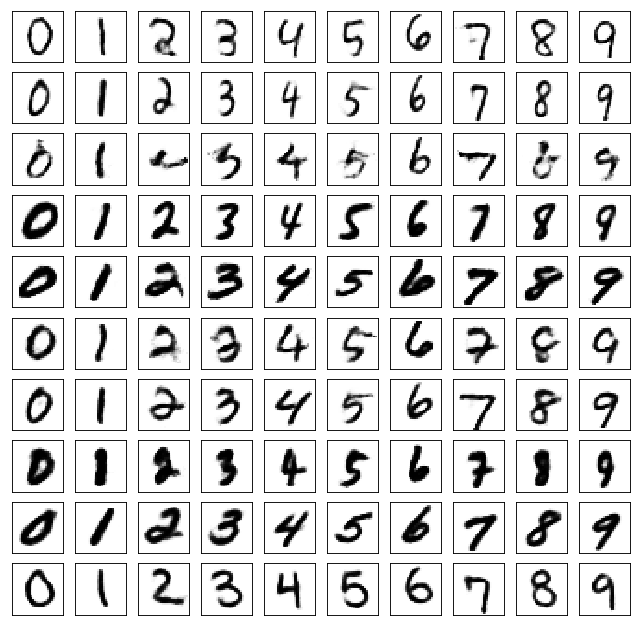

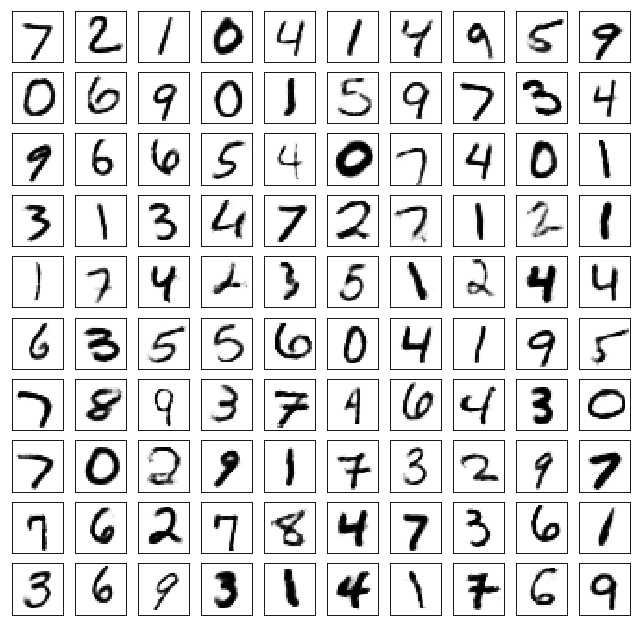

Test losses. E: 0.6948, AE: 0.0532, D: 0.6920
Train Epoch: 1401 [0/50000 (0%)]	Losses E: 0.6978, AE: 0.0187, D: 0.6921
Train Epoch: 1401 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0183, D: 0.6932
Train Epoch: 1401 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0195, D: 0.6923
Test losses. E: 0.6940, AE: 0.0532, D: 0.6919
Train Epoch: 1402 [0/50000 (0%)]	Losses E: 0.6950, AE: 0.0186, D: 0.6920
Train Epoch: 1402 [25000/50000 (50%)]	Losses E: 0.6964, AE: 0.0193, D: 0.6897
Train Epoch: 1402 [50000/50000 (100%)]	Losses E: 0.6942, AE: 0.0188, D: 0.6894
Test losses. E: 0.6941, AE: 0.0532, D: 0.6921
Train Epoch: 1403 [0/50000 (0%)]	Losses E: 0.6941, AE: 0.0178, D: 0.6918
Train Epoch: 1403 [25000/50000 (50%)]	Losses E: 0.6959, AE: 0.0199, D: 0.6941
Train Epoch: 1403 [50000/50000 (100%)]	Losses E: 0.6896, AE: 0.0196, D: 0.6937
Test losses. E: 0.6938, AE: 0.0532, D: 0.6921
Train Epoch: 1404 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0195, D: 0.6912
Train Epoch: 1404 [25000/50000 (50%)]	Losses E: 0.695

Train Epoch: 1430 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0185, D: 0.6920
Test losses. E: 0.6931, AE: 0.0532, D: 0.6921
Train Epoch: 1431 [0/50000 (0%)]	Losses E: 0.6943, AE: 0.0196, D: 0.6906
Train Epoch: 1431 [25000/50000 (50%)]	Losses E: 0.6939, AE: 0.0195, D: 0.6936
Train Epoch: 1431 [50000/50000 (100%)]	Losses E: 0.6948, AE: 0.0191, D: 0.6957
Test losses. E: 0.6934, AE: 0.0532, D: 0.6921
Train Epoch: 1432 [0/50000 (0%)]	Losses E: 0.6965, AE: 0.0198, D: 0.6914
Train Epoch: 1432 [25000/50000 (50%)]	Losses E: 0.6943, AE: 0.0194, D: 0.6917
Train Epoch: 1432 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0186, D: 0.6931
Test losses. E: 0.6937, AE: 0.0533, D: 0.6919
Train Epoch: 1433 [0/50000 (0%)]	Losses E: 0.6991, AE: 0.0167, D: 0.6898
Train Epoch: 1433 [25000/50000 (50%)]	Losses E: 0.6972, AE: 0.0185, D: 0.6945
Train Epoch: 1433 [50000/50000 (100%)]	Losses E: 0.6970, AE: 0.0184, D: 0.6914
Test losses. E: 0.6934, AE: 0.0533, D: 0.6921
Train Epoch: 1434 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1460 [25000/50000 (50%)]	Losses E: 0.6957, AE: 0.0185, D: 0.6902
Train Epoch: 1460 [50000/50000 (100%)]	Losses E: 0.6917, AE: 0.0184, D: 0.6934
Test losses. E: 0.6941, AE: 0.0533, D: 0.6921
Train Epoch: 1461 [0/50000 (0%)]	Losses E: 0.6968, AE: 0.0188, D: 0.6917
Train Epoch: 1461 [25000/50000 (50%)]	Losses E: 0.6946, AE: 0.0190, D: 0.6932
Train Epoch: 1461 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0197, D: 0.6932
Test losses. E: 0.6944, AE: 0.0534, D: 0.6920
Train Epoch: 1462 [0/50000 (0%)]	Losses E: 0.6961, AE: 0.0192, D: 0.6909
Train Epoch: 1462 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0193, D: 0.6927
Train Epoch: 1462 [50000/50000 (100%)]	Losses E: 0.6949, AE: 0.0190, D: 0.6913
Test losses. E: 0.6943, AE: 0.0533, D: 0.6921
Train Epoch: 1463 [0/50000 (0%)]	Losses E: 0.6961, AE: 0.0187, D: 0.6908
Train Epoch: 1463 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.0204, D: 0.6929
Train Epoch: 1463 [50000/50000 (100%)]	Losses E: 0.6997, AE: 0.0193, D: 0.6930
Test losses. E:

Train Epoch: 1490 [25000/50000 (50%)]	Losses E: 0.6910, AE: 0.0193, D: 0.6952
Train Epoch: 1490 [50000/50000 (100%)]	Losses E: 0.6944, AE: 0.0208, D: 0.6936
Test losses. E: 0.6943, AE: 0.0535, D: 0.6921
Train Epoch: 1491 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0181, D: 0.6915
Train Epoch: 1491 [25000/50000 (50%)]	Losses E: 0.6960, AE: 0.0197, D: 0.6917
Train Epoch: 1491 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0210, D: 0.6955
Test losses. E: 0.6933, AE: 0.0534, D: 0.6920
Train Epoch: 1492 [0/50000 (0%)]	Losses E: 0.6976, AE: 0.0201, D: 0.6936
Train Epoch: 1492 [25000/50000 (50%)]	Losses E: 0.7002, AE: 0.0178, D: 0.6923
Train Epoch: 1492 [50000/50000 (100%)]	Losses E: 0.6957, AE: 0.0192, D: 0.6916
Test losses. E: 0.6936, AE: 0.0534, D: 0.6919
Train Epoch: 1493 [0/50000 (0%)]	Losses E: 0.6951, AE: 0.0200, D: 0.6914
Train Epoch: 1493 [25000/50000 (50%)]	Losses E: 0.7002, AE: 0.0186, D: 0.6918
Train Epoch: 1493 [50000/50000 (100%)]	Losses E: 0.6938, AE: 0.0195, D: 0.6960
Test losses. E:

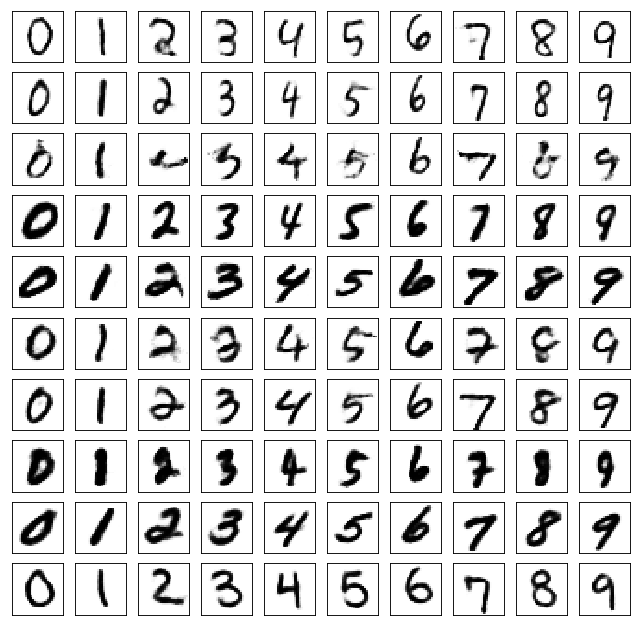

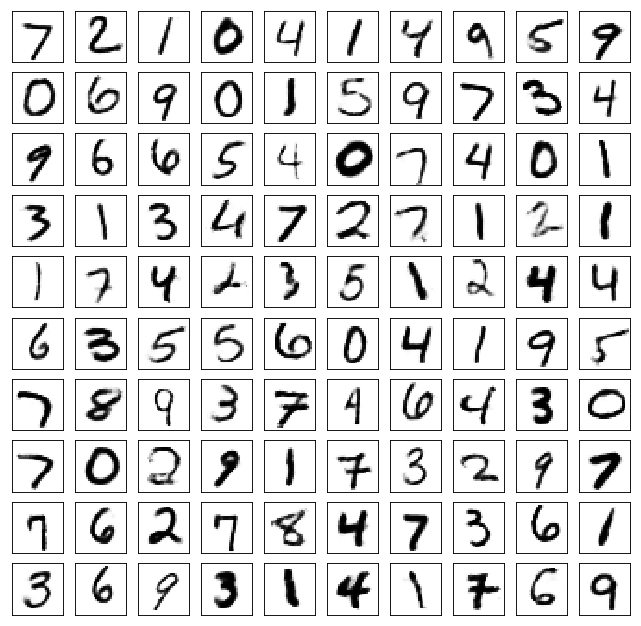

Test losses. E: 0.6937, AE: 0.0535, D: 0.6919
Train Epoch: 1501 [0/50000 (0%)]	Losses E: 0.6918, AE: 0.0188, D: 0.6929
Train Epoch: 1501 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0185, D: 0.6926
Train Epoch: 1501 [50000/50000 (100%)]	Losses E: 0.6904, AE: 0.0204, D: 0.6943
Test losses. E: 0.6934, AE: 0.0534, D: 0.6922
Train Epoch: 1502 [0/50000 (0%)]	Losses E: 0.6952, AE: 0.0191, D: 0.6936
Train Epoch: 1502 [25000/50000 (50%)]	Losses E: 0.6937, AE: 0.0184, D: 0.6936
Train Epoch: 1502 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0196, D: 0.6919
Test losses. E: 0.6934, AE: 0.0535, D: 0.6922
Train Epoch: 1503 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0192, D: 0.6922
Train Epoch: 1503 [25000/50000 (50%)]	Losses E: 0.6928, AE: 0.0197, D: 0.6932
Train Epoch: 1503 [50000/50000 (100%)]	Losses E: 0.6980, AE: 0.0197, D: 0.6900
Test losses. E: 0.6940, AE: 0.0535, D: 0.6920
Train Epoch: 1504 [0/50000 (0%)]	Losses E: 0.6940, AE: 0.0191, D: 0.6928
Train Epoch: 1504 [25000/50000 (50%)]	Losses E: 0.698

Train Epoch: 1530 [50000/50000 (100%)]	Losses E: 0.6933, AE: 0.0193, D: 0.6912
Test losses. E: 0.6934, AE: 0.0535, D: 0.6923
Train Epoch: 1531 [0/50000 (0%)]	Losses E: 0.6931, AE: 0.0193, D: 0.6949
Train Epoch: 1531 [25000/50000 (50%)]	Losses E: 0.6916, AE: 0.0184, D: 0.6919
Train Epoch: 1531 [50000/50000 (100%)]	Losses E: 0.6954, AE: 0.0183, D: 0.6914
Test losses. E: 0.6928, AE: 0.0535, D: 0.6921
Train Epoch: 1532 [0/50000 (0%)]	Losses E: 0.6929, AE: 0.0192, D: 0.6909
Train Epoch: 1532 [25000/50000 (50%)]	Losses E: 0.6970, AE: 0.0196, D: 0.6922
Train Epoch: 1532 [50000/50000 (100%)]	Losses E: 0.6933, AE: 0.0196, D: 0.6918
Test losses. E: 0.6935, AE: 0.0535, D: 0.6918
Train Epoch: 1533 [0/50000 (0%)]	Losses E: 0.6968, AE: 0.0185, D: 0.6948
Train Epoch: 1533 [25000/50000 (50%)]	Losses E: 0.6969, AE: 0.0195, D: 0.6914
Train Epoch: 1533 [50000/50000 (100%)]	Losses E: 0.6961, AE: 0.0194, D: 0.6912
Test losses. E: 0.6942, AE: 0.0535, D: 0.6921
Train Epoch: 1534 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1560 [25000/50000 (50%)]	Losses E: 0.6956, AE: 0.0185, D: 0.6922
Train Epoch: 1560 [50000/50000 (100%)]	Losses E: 0.6956, AE: 0.0185, D: 0.6925
Test losses. E: 0.6936, AE: 0.0536, D: 0.6921
Train Epoch: 1561 [0/50000 (0%)]	Losses E: 0.6974, AE: 0.0183, D: 0.6900
Train Epoch: 1561 [25000/50000 (50%)]	Losses E: 0.6942, AE: 0.0189, D: 0.6911
Train Epoch: 1561 [50000/50000 (100%)]	Losses E: 0.6971, AE: 0.0179, D: 0.6913
Test losses. E: 0.6941, AE: 0.0537, D: 0.6920
Train Epoch: 1562 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0185, D: 0.6925
Train Epoch: 1562 [25000/50000 (50%)]	Losses E: 0.6993, AE: 0.0189, D: 0.6912
Train Epoch: 1562 [50000/50000 (100%)]	Losses E: 0.6972, AE: 0.0187, D: 0.6924
Test losses. E: 0.6940, AE: 0.0536, D: 0.6919
Train Epoch: 1563 [0/50000 (0%)]	Losses E: 0.6992, AE: 0.0179, D: 0.6934
Train Epoch: 1563 [25000/50000 (50%)]	Losses E: 0.6930, AE: 0.0183, D: 0.6923
Train Epoch: 1563 [50000/50000 (100%)]	Losses E: 0.6970, AE: 0.0184, D: 0.6916
Test losses. E:

Train Epoch: 1590 [25000/50000 (50%)]	Losses E: 0.6931, AE: 0.0192, D: 0.6939
Train Epoch: 1590 [50000/50000 (100%)]	Losses E: 0.6947, AE: 0.0175, D: 0.6923
Test losses. E: 0.6939, AE: 0.0537, D: 0.6918
Train Epoch: 1591 [0/50000 (0%)]	Losses E: 0.6993, AE: 0.0180, D: 0.6896
Train Epoch: 1591 [25000/50000 (50%)]	Losses E: 0.6943, AE: 0.0200, D: 0.6934
Train Epoch: 1591 [50000/50000 (100%)]	Losses E: 0.6917, AE: 0.0192, D: 0.6914
Test losses. E: 0.6939, AE: 0.0537, D: 0.6920
Train Epoch: 1592 [0/50000 (0%)]	Losses E: 0.6968, AE: 0.0195, D: 0.6907
Train Epoch: 1592 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0212, D: 0.6932
Train Epoch: 1592 [50000/50000 (100%)]	Losses E: 0.6972, AE: 0.0181, D: 0.6914
Test losses. E: 0.6934, AE: 0.0536, D: 0.6921
Train Epoch: 1593 [0/50000 (0%)]	Losses E: 0.6929, AE: 0.0189, D: 0.6920
Train Epoch: 1593 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0209, D: 0.6924
Train Epoch: 1593 [50000/50000 (100%)]	Losses E: 0.6942, AE: 0.0202, D: 0.6902
Test losses. E:

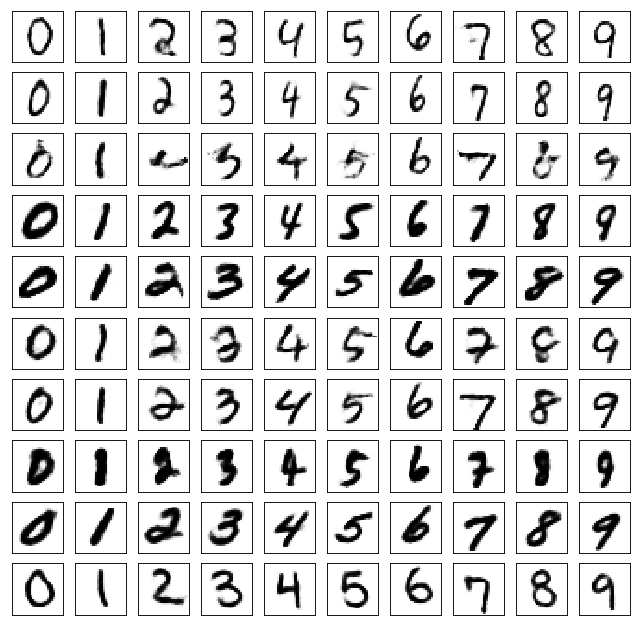

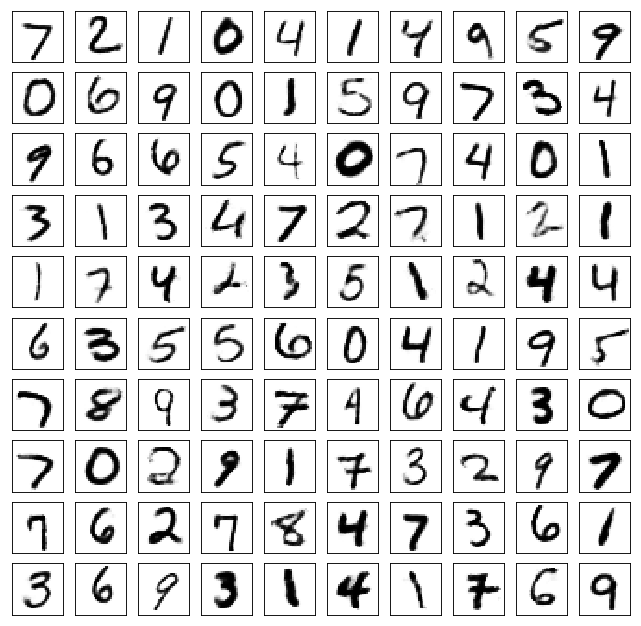

Test losses. E: 0.6933, AE: 0.0537, D: 0.6920
Train Epoch: 1601 [0/50000 (0%)]	Losses E: 0.6990, AE: 0.0196, D: 0.6897
Train Epoch: 1601 [25000/50000 (50%)]	Losses E: 0.6957, AE: 0.0190, D: 0.6915
Train Epoch: 1601 [50000/50000 (100%)]	Losses E: 0.6983, AE: 0.0183, D: 0.6909
Test losses. E: 0.6942, AE: 0.0537, D: 0.6917
Train Epoch: 1602 [0/50000 (0%)]	Losses E: 0.6945, AE: 0.0196, D: 0.6924
Train Epoch: 1602 [25000/50000 (50%)]	Losses E: 0.6954, AE: 0.0195, D: 0.6939
Train Epoch: 1602 [50000/50000 (100%)]	Losses E: 0.6983, AE: 0.0185, D: 0.6947
Test losses. E: 0.6938, AE: 0.0537, D: 0.6921
Train Epoch: 1603 [0/50000 (0%)]	Losses E: 0.6973, AE: 0.0191, D: 0.6944
Train Epoch: 1603 [25000/50000 (50%)]	Losses E: 0.6902, AE: 0.0199, D: 0.6936
Train Epoch: 1603 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0184, D: 0.6933
Test losses. E: 0.6940, AE: 0.0537, D: 0.6920
Train Epoch: 1604 [0/50000 (0%)]	Losses E: 0.6960, AE: 0.0190, D: 0.6906
Train Epoch: 1604 [25000/50000 (50%)]	Losses E: 0.698

Train Epoch: 1630 [50000/50000 (100%)]	Losses E: 0.6961, AE: 0.0197, D: 0.6916
Test losses. E: 0.6946, AE: 0.0537, D: 0.6922
Train Epoch: 1631 [0/50000 (0%)]	Losses E: 0.6940, AE: 0.0185, D: 0.6920
Train Epoch: 1631 [25000/50000 (50%)]	Losses E: 0.6965, AE: 0.0178, D: 0.6920
Train Epoch: 1631 [50000/50000 (100%)]	Losses E: 0.6956, AE: 0.0190, D: 0.6932
Test losses. E: 0.6938, AE: 0.0538, D: 0.6921
Train Epoch: 1632 [0/50000 (0%)]	Losses E: 0.6980, AE: 0.0199, D: 0.6884
Train Epoch: 1632 [25000/50000 (50%)]	Losses E: 0.6940, AE: 0.0188, D: 0.6909
Train Epoch: 1632 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.0196, D: 0.6917
Test losses. E: 0.6942, AE: 0.0538, D: 0.6919
Train Epoch: 1633 [0/50000 (0%)]	Losses E: 0.6965, AE: 0.0187, D: 0.6920
Train Epoch: 1633 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0193, D: 0.6899
Train Epoch: 1633 [50000/50000 (100%)]	Losses E: 0.6925, AE: 0.0189, D: 0.6905
Test losses. E: 0.6935, AE: 0.0537, D: 0.6921
Train Epoch: 1634 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1660 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0191, D: 0.6941
Train Epoch: 1660 [50000/50000 (100%)]	Losses E: 0.6988, AE: 0.0193, D: 0.6925
Test losses. E: 0.6938, AE: 0.0539, D: 0.6921
Train Epoch: 1661 [0/50000 (0%)]	Losses E: 0.6936, AE: 0.0189, D: 0.6908
Train Epoch: 1661 [25000/50000 (50%)]	Losses E: 0.6948, AE: 0.0183, D: 0.6916
Train Epoch: 1661 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0191, D: 0.6949
Test losses. E: 0.6943, AE: 0.0539, D: 0.6923
Train Epoch: 1662 [0/50000 (0%)]	Losses E: 0.6978, AE: 0.0193, D: 0.6908
Train Epoch: 1662 [25000/50000 (50%)]	Losses E: 0.6946, AE: 0.0194, D: 0.6931
Train Epoch: 1662 [50000/50000 (100%)]	Losses E: 0.6943, AE: 0.0182, D: 0.6929
Test losses. E: 0.6937, AE: 0.0538, D: 0.6921
Train Epoch: 1663 [0/50000 (0%)]	Losses E: 0.6963, AE: 0.0189, D: 0.6899
Train Epoch: 1663 [25000/50000 (50%)]	Losses E: 0.6968, AE: 0.0180, D: 0.6888
Train Epoch: 1663 [50000/50000 (100%)]	Losses E: 0.6945, AE: 0.0187, D: 0.6932
Test losses. E:

Train Epoch: 1690 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0193, D: 0.6919
Train Epoch: 1690 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.0177, D: 0.6918
Test losses. E: 0.6938, AE: 0.0539, D: 0.6920
Train Epoch: 1691 [0/50000 (0%)]	Losses E: 0.6942, AE: 0.0188, D: 0.6902
Train Epoch: 1691 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0196, D: 0.6959
Train Epoch: 1691 [50000/50000 (100%)]	Losses E: 0.6964, AE: 0.0189, D: 0.6930
Test losses. E: 0.6942, AE: 0.0540, D: 0.6921
Train Epoch: 1692 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0187, D: 0.6941
Train Epoch: 1692 [25000/50000 (50%)]	Losses E: 0.6997, AE: 0.0186, D: 0.6929
Train Epoch: 1692 [50000/50000 (100%)]	Losses E: 0.6929, AE: 0.0191, D: 0.6947
Test losses. E: 0.6941, AE: 0.0540, D: 0.6920
Train Epoch: 1693 [0/50000 (0%)]	Losses E: 0.6943, AE: 0.0198, D: 0.6898
Train Epoch: 1693 [25000/50000 (50%)]	Losses E: 0.6946, AE: 0.0181, D: 0.6933
Train Epoch: 1693 [50000/50000 (100%)]	Losses E: 0.6963, AE: 0.0178, D: 0.6909
Test losses. E:

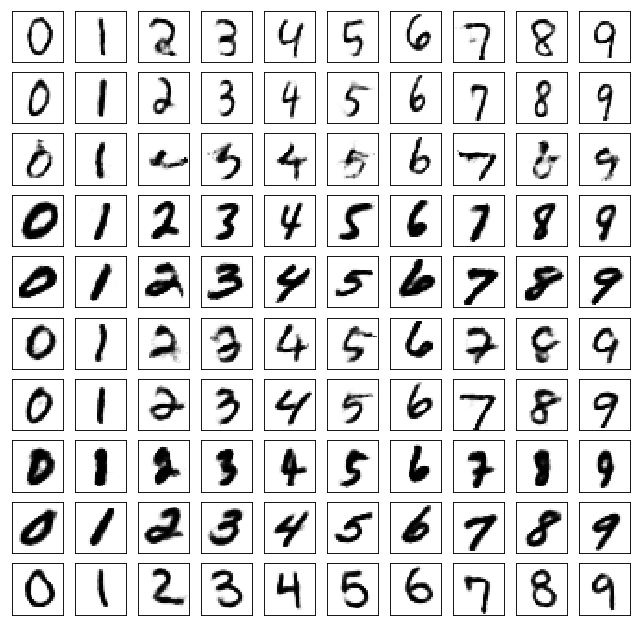

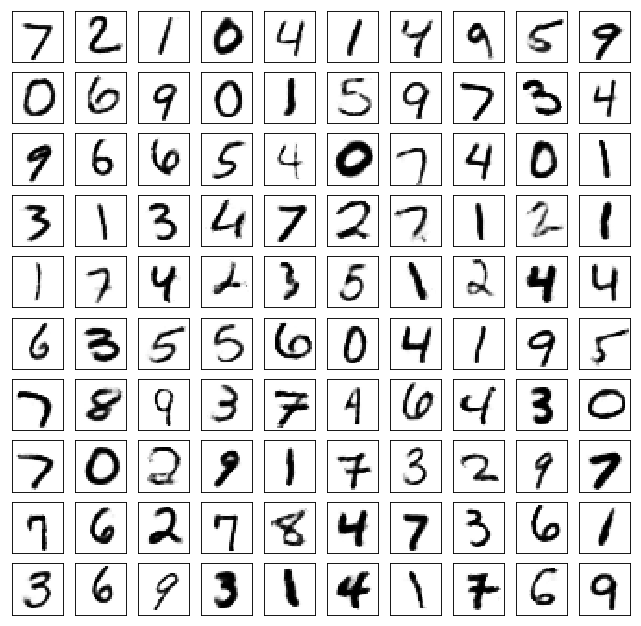

Test losses. E: 0.6937, AE: 0.0540, D: 0.6922
Train Epoch: 1701 [0/50000 (0%)]	Losses E: 0.6945, AE: 0.0176, D: 0.6911
Train Epoch: 1701 [25000/50000 (50%)]	Losses E: 0.6957, AE: 0.0187, D: 0.6930
Train Epoch: 1701 [50000/50000 (100%)]	Losses E: 0.6926, AE: 0.0190, D: 0.6899
Test losses. E: 0.6937, AE: 0.0539, D: 0.6921
Train Epoch: 1702 [0/50000 (0%)]	Losses E: 0.6989, AE: 0.0181, D: 0.6938
Train Epoch: 1702 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0196, D: 0.6904
Train Epoch: 1702 [50000/50000 (100%)]	Losses E: 0.6926, AE: 0.0189, D: 0.6927
Test losses. E: 0.6935, AE: 0.0540, D: 0.6920
Train Epoch: 1703 [0/50000 (0%)]	Losses E: 0.6932, AE: 0.0189, D: 0.6920
Train Epoch: 1703 [25000/50000 (50%)]	Losses E: 0.6964, AE: 0.0188, D: 0.6913
Train Epoch: 1703 [50000/50000 (100%)]	Losses E: 0.6971, AE: 0.0198, D: 0.6921
Test losses. E: 0.6938, AE: 0.0539, D: 0.6921
Train Epoch: 1704 [0/50000 (0%)]	Losses E: 0.6951, AE: 0.0195, D: 0.6909
Train Epoch: 1704 [25000/50000 (50%)]	Losses E: 0.694

Train Epoch: 1730 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0179, D: 0.6899
Test losses. E: 0.6937, AE: 0.0539, D: 0.6920
Train Epoch: 1731 [0/50000 (0%)]	Losses E: 0.6973, AE: 0.0170, D: 0.6916
Train Epoch: 1731 [25000/50000 (50%)]	Losses E: 0.6919, AE: 0.0193, D: 0.6920
Train Epoch: 1731 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0181, D: 0.6919
Test losses. E: 0.6941, AE: 0.0540, D: 0.6920
Train Epoch: 1732 [0/50000 (0%)]	Losses E: 0.6923, AE: 0.0193, D: 0.6958
Train Epoch: 1732 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0180, D: 0.6922
Train Epoch: 1732 [50000/50000 (100%)]	Losses E: 0.6977, AE: 0.0184, D: 0.6929
Test losses. E: 0.6940, AE: 0.0540, D: 0.6921
Train Epoch: 1733 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0186, D: 0.6941
Train Epoch: 1733 [25000/50000 (50%)]	Losses E: 0.6938, AE: 0.0190, D: 0.6898
Train Epoch: 1733 [50000/50000 (100%)]	Losses E: 0.6961, AE: 0.0190, D: 0.6935
Test losses. E: 0.6940, AE: 0.0540, D: 0.6921
Train Epoch: 1734 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1760 [25000/50000 (50%)]	Losses E: 0.6984, AE: 0.0187, D: 0.6933
Train Epoch: 1760 [50000/50000 (100%)]	Losses E: 0.6982, AE: 0.0180, D: 0.6901
Test losses. E: 0.6936, AE: 0.0540, D: 0.6923
Train Epoch: 1761 [0/50000 (0%)]	Losses E: 0.6959, AE: 0.0183, D: 0.6911
Train Epoch: 1761 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0187, D: 0.6893
Train Epoch: 1761 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0196, D: 0.6903
Test losses. E: 0.6934, AE: 0.0541, D: 0.6920
Train Epoch: 1762 [0/50000 (0%)]	Losses E: 0.6925, AE: 0.0183, D: 0.6930
Train Epoch: 1762 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0189, D: 0.6909
Train Epoch: 1762 [50000/50000 (100%)]	Losses E: 0.6947, AE: 0.0180, D: 0.6902
Test losses. E: 0.6947, AE: 0.0541, D: 0.6919
Train Epoch: 1763 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0182, D: 0.6893
Train Epoch: 1763 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0189, D: 0.6924
Train Epoch: 1763 [50000/50000 (100%)]	Losses E: 0.6976, AE: 0.0183, D: 0.6910
Test losses. E:

Train Epoch: 1790 [25000/50000 (50%)]	Losses E: 0.6957, AE: 0.0186, D: 0.6910
Train Epoch: 1790 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0182, D: 0.6931
Test losses. E: 0.6939, AE: 0.0542, D: 0.6921
Train Epoch: 1791 [0/50000 (0%)]	Losses E: 0.6937, AE: 0.0179, D: 0.6938
Train Epoch: 1791 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0195, D: 0.6905
Train Epoch: 1791 [50000/50000 (100%)]	Losses E: 0.6947, AE: 0.0188, D: 0.6925
Test losses. E: 0.6938, AE: 0.0541, D: 0.6921
Train Epoch: 1792 [0/50000 (0%)]	Losses E: 0.7002, AE: 0.0184, D: 0.6892
Train Epoch: 1792 [25000/50000 (50%)]	Losses E: 0.6988, AE: 0.0187, D: 0.6949
Train Epoch: 1792 [50000/50000 (100%)]	Losses E: 0.6920, AE: 0.0189, D: 0.6922
Test losses. E: 0.6935, AE: 0.0541, D: 0.6919
Train Epoch: 1793 [0/50000 (0%)]	Losses E: 0.6929, AE: 0.0196, D: 0.6932
Train Epoch: 1793 [25000/50000 (50%)]	Losses E: 0.6940, AE: 0.0200, D: 0.6922
Train Epoch: 1793 [50000/50000 (100%)]	Losses E: 0.6962, AE: 0.0194, D: 0.6914
Test losses. E:

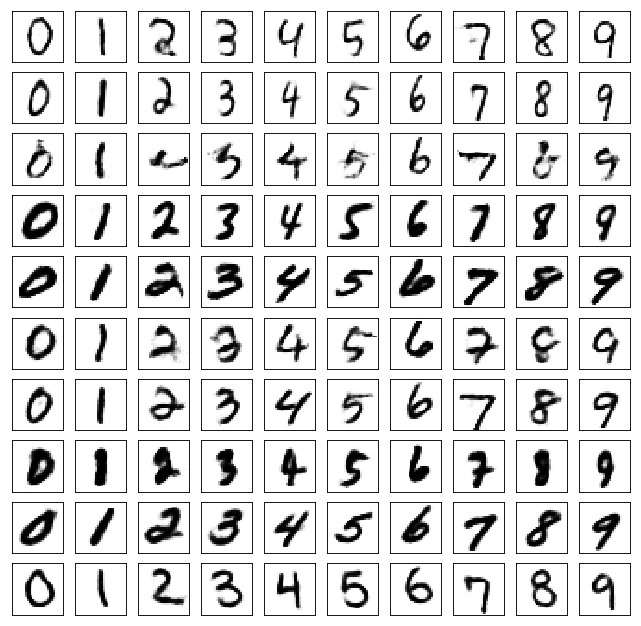

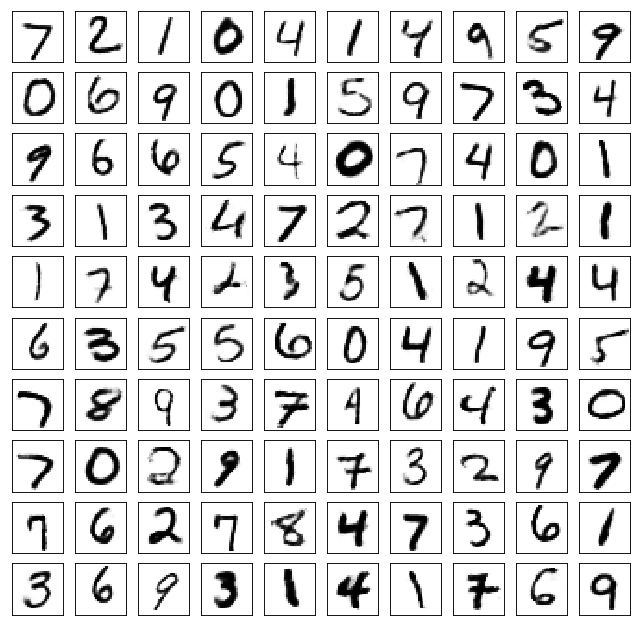

Test losses. E: 0.6946, AE: 0.0541, D: 0.6919
Train Epoch: 1801 [0/50000 (0%)]	Losses E: 0.7014, AE: 0.0185, D: 0.6883
Train Epoch: 1801 [25000/50000 (50%)]	Losses E: 0.6944, AE: 0.0186, D: 0.6923
Train Epoch: 1801 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0196, D: 0.6897
Test losses. E: 0.6939, AE: 0.0542, D: 0.6921
Train Epoch: 1802 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0188, D: 0.6927
Train Epoch: 1802 [25000/50000 (50%)]	Losses E: 0.6932, AE: 0.0186, D: 0.6949
Train Epoch: 1802 [50000/50000 (100%)]	Losses E: 0.6946, AE: 0.0191, D: 0.6905
Test losses. E: 0.6935, AE: 0.0542, D: 0.6920
Train Epoch: 1803 [0/50000 (0%)]	Losses E: 0.6934, AE: 0.0180, D: 0.6913
Train Epoch: 1803 [25000/50000 (50%)]	Losses E: 0.6966, AE: 0.0185, D: 0.6921
Train Epoch: 1803 [50000/50000 (100%)]	Losses E: 0.6915, AE: 0.0186, D: 0.6925
Test losses. E: 0.6944, AE: 0.0542, D: 0.6921
Train Epoch: 1804 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0186, D: 0.6951
Train Epoch: 1804 [25000/50000 (50%)]	Losses E: 0.693

Train Epoch: 1830 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0201, D: 0.6923
Test losses. E: 0.6939, AE: 0.0543, D: 0.6920
Train Epoch: 1831 [0/50000 (0%)]	Losses E: 0.6949, AE: 0.0189, D: 0.6921
Train Epoch: 1831 [25000/50000 (50%)]	Losses E: 0.6931, AE: 0.0199, D: 0.6932
Train Epoch: 1831 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0187, D: 0.6913
Test losses. E: 0.6939, AE: 0.0542, D: 0.6920
Train Epoch: 1832 [0/50000 (0%)]	Losses E: 0.6995, AE: 0.0177, D: 0.6893
Train Epoch: 1832 [25000/50000 (50%)]	Losses E: 0.6932, AE: 0.0195, D: 0.6935
Train Epoch: 1832 [50000/50000 (100%)]	Losses E: 0.7025, AE: 0.0182, D: 0.6924
Test losses. E: 0.6941, AE: 0.0543, D: 0.6921
Train Epoch: 1833 [0/50000 (0%)]	Losses E: 0.6959, AE: 0.0178, D: 0.6922
Train Epoch: 1833 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0191, D: 0.6910
Train Epoch: 1833 [50000/50000 (100%)]	Losses E: 0.6901, AE: 0.0194, D: 0.6941
Test losses. E: 0.6937, AE: 0.0542, D: 0.6918
Train Epoch: 1834 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1860 [25000/50000 (50%)]	Losses E: 0.6967, AE: 0.0185, D: 0.6919
Train Epoch: 1860 [50000/50000 (100%)]	Losses E: 0.6915, AE: 0.0193, D: 0.6938
Test losses. E: 0.6939, AE: 0.0544, D: 0.6918
Train Epoch: 1861 [0/50000 (0%)]	Losses E: 0.6999, AE: 0.0197, D: 0.6916
Train Epoch: 1861 [25000/50000 (50%)]	Losses E: 0.6970, AE: 0.0189, D: 0.6920
Train Epoch: 1861 [50000/50000 (100%)]	Losses E: 0.6988, AE: 0.0195, D: 0.6939
Test losses. E: 0.6946, AE: 0.0543, D: 0.6920
Train Epoch: 1862 [0/50000 (0%)]	Losses E: 0.7013, AE: 0.0180, D: 0.6920
Train Epoch: 1862 [25000/50000 (50%)]	Losses E: 0.6897, AE: 0.0187, D: 0.6926
Train Epoch: 1862 [50000/50000 (100%)]	Losses E: 0.6941, AE: 0.0192, D: 0.6921
Test losses. E: 0.6935, AE: 0.0543, D: 0.6921
Train Epoch: 1863 [0/50000 (0%)]	Losses E: 0.6958, AE: 0.0182, D: 0.6897
Train Epoch: 1863 [25000/50000 (50%)]	Losses E: 0.6954, AE: 0.0189, D: 0.6889
Train Epoch: 1863 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0192, D: 0.6920
Test losses. E:

Train Epoch: 1890 [25000/50000 (50%)]	Losses E: 0.6968, AE: 0.0185, D: 0.6894
Train Epoch: 1890 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0188, D: 0.6898
Test losses. E: 0.6939, AE: 0.0544, D: 0.6921
Train Epoch: 1891 [0/50000 (0%)]	Losses E: 0.6933, AE: 0.0200, D: 0.6943
Train Epoch: 1891 [25000/50000 (50%)]	Losses E: 0.6938, AE: 0.0189, D: 0.6895
Train Epoch: 1891 [50000/50000 (100%)]	Losses E: 0.6977, AE: 0.0182, D: 0.6925
Test losses. E: 0.6942, AE: 0.0544, D: 0.6921
Train Epoch: 1892 [0/50000 (0%)]	Losses E: 0.6968, AE: 0.0192, D: 0.6913
Train Epoch: 1892 [25000/50000 (50%)]	Losses E: 0.6990, AE: 0.0199, D: 0.6927
Train Epoch: 1892 [50000/50000 (100%)]	Losses E: 0.6964, AE: 0.0194, D: 0.6894
Test losses. E: 0.6933, AE: 0.0544, D: 0.6919
Train Epoch: 1893 [0/50000 (0%)]	Losses E: 0.6939, AE: 0.0184, D: 0.6940
Train Epoch: 1893 [25000/50000 (50%)]	Losses E: 0.6995, AE: 0.0189, D: 0.6910
Train Epoch: 1893 [50000/50000 (100%)]	Losses E: 0.6951, AE: 0.0179, D: 0.6900
Test losses. E:

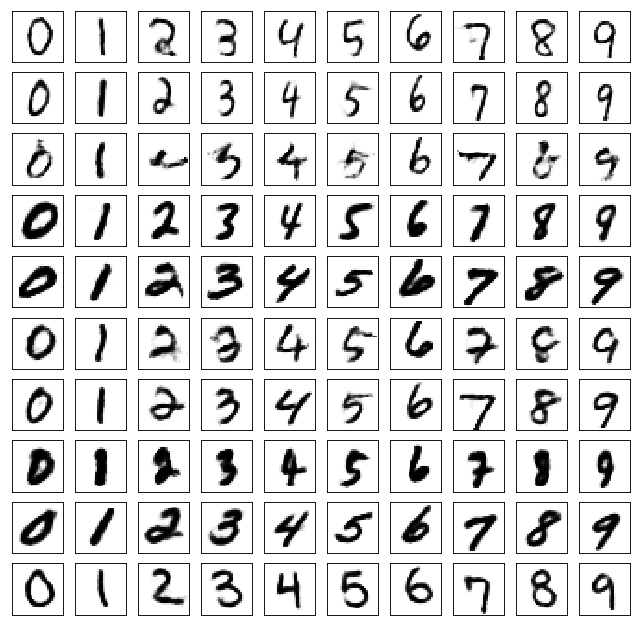

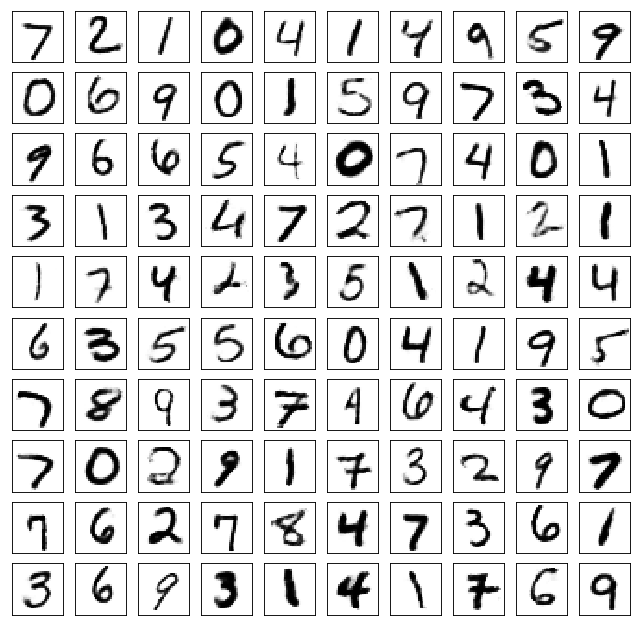

Test losses. E: 0.6939, AE: 0.0544, D: 0.6917
Train Epoch: 1901 [0/50000 (0%)]	Losses E: 0.6954, AE: 0.0189, D: 0.6944
Train Epoch: 1901 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0183, D: 0.6942
Train Epoch: 1901 [50000/50000 (100%)]	Losses E: 0.6973, AE: 0.0177, D: 0.6937
Test losses. E: 0.6938, AE: 0.0544, D: 0.6917
Train Epoch: 1902 [0/50000 (0%)]	Losses E: 0.6920, AE: 0.0179, D: 0.6928
Train Epoch: 1902 [25000/50000 (50%)]	Losses E: 0.6946, AE: 0.0185, D: 0.6928
Train Epoch: 1902 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0190, D: 0.6929
Test losses. E: 0.6936, AE: 0.0543, D: 0.6919
Train Epoch: 1903 [0/50000 (0%)]	Losses E: 0.6960, AE: 0.0190, D: 0.6931
Train Epoch: 1903 [25000/50000 (50%)]	Losses E: 0.6975, AE: 0.0181, D: 0.6889
Train Epoch: 1903 [50000/50000 (100%)]	Losses E: 0.6979, AE: 0.0177, D: 0.6912
Test losses. E: 0.6935, AE: 0.0544, D: 0.6922
Train Epoch: 1904 [0/50000 (0%)]	Losses E: 0.6973, AE: 0.0182, D: 0.6915
Train Epoch: 1904 [25000/50000 (50%)]	Losses E: 0.694

Train Epoch: 1930 [50000/50000 (100%)]	Losses E: 0.6968, AE: 0.0187, D: 0.6904
Test losses. E: 0.6932, AE: 0.0544, D: 0.6919
Train Epoch: 1931 [0/50000 (0%)]	Losses E: 0.6981, AE: 0.0193, D: 0.6926
Train Epoch: 1931 [25000/50000 (50%)]	Losses E: 0.6935, AE: 0.0181, D: 0.6926
Train Epoch: 1931 [50000/50000 (100%)]	Losses E: 0.7002, AE: 0.0185, D: 0.6910
Test losses. E: 0.6935, AE: 0.0544, D: 0.6921
Train Epoch: 1932 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0197, D: 0.6952
Train Epoch: 1932 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0196, D: 0.6925
Train Epoch: 1932 [50000/50000 (100%)]	Losses E: 0.6947, AE: 0.0192, D: 0.6919
Test losses. E: 0.6930, AE: 0.0544, D: 0.6919
Train Epoch: 1933 [0/50000 (0%)]	Losses E: 0.6948, AE: 0.0176, D: 0.6918
Train Epoch: 1933 [25000/50000 (50%)]	Losses E: 0.6957, AE: 0.0180, D: 0.6894
Train Epoch: 1933 [50000/50000 (100%)]	Losses E: 0.6951, AE: 0.0190, D: 0.6917
Test losses. E: 0.6944, AE: 0.0545, D: 0.6920
Train Epoch: 1934 [0/50000 (0%)]	Losses E: 0.69

Train Epoch: 1960 [25000/50000 (50%)]	Losses E: 0.6947, AE: 0.0188, D: 0.6918
Train Epoch: 1960 [50000/50000 (100%)]	Losses E: 0.6990, AE: 0.0186, D: 0.6932
Test losses. E: 0.6943, AE: 0.0546, D: 0.6919
Train Epoch: 1961 [0/50000 (0%)]	Losses E: 0.6954, AE: 0.0177, D: 0.6919
Train Epoch: 1961 [25000/50000 (50%)]	Losses E: 0.6956, AE: 0.0179, D: 0.6943
Train Epoch: 1961 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0181, D: 0.6892
Test losses. E: 0.6937, AE: 0.0545, D: 0.6921
Train Epoch: 1962 [0/50000 (0%)]	Losses E: 0.6949, AE: 0.0187, D: 0.6933
Train Epoch: 1962 [25000/50000 (50%)]	Losses E: 0.6998, AE: 0.0183, D: 0.6919
Train Epoch: 1962 [50000/50000 (100%)]	Losses E: 0.6954, AE: 0.0191, D: 0.6910
Test losses. E: 0.6936, AE: 0.0546, D: 0.6919
Train Epoch: 1963 [0/50000 (0%)]	Losses E: 0.6949, AE: 0.0198, D: 0.6917
Train Epoch: 1963 [25000/50000 (50%)]	Losses E: 0.6935, AE: 0.0189, D: 0.6950
Train Epoch: 1963 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0180, D: 0.6920
Test losses. E:

Train Epoch: 1990 [25000/50000 (50%)]	Losses E: 0.6922, AE: 0.0189, D: 0.6914
Train Epoch: 1990 [50000/50000 (100%)]	Losses E: 0.6953, AE: 0.0196, D: 0.6907
Test losses. E: 0.6935, AE: 0.0545, D: 0.6922
Train Epoch: 1991 [0/50000 (0%)]	Losses E: 0.6943, AE: 0.0183, D: 0.6928
Train Epoch: 1991 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0191, D: 0.6911
Train Epoch: 1991 [50000/50000 (100%)]	Losses E: 0.6941, AE: 0.0198, D: 0.6938
Test losses. E: 0.6935, AE: 0.0545, D: 0.6919
Train Epoch: 1992 [0/50000 (0%)]	Losses E: 0.6940, AE: 0.0182, D: 0.6943
Train Epoch: 1992 [25000/50000 (50%)]	Losses E: 0.6938, AE: 0.0183, D: 0.6938
Train Epoch: 1992 [50000/50000 (100%)]	Losses E: 0.6928, AE: 0.0205, D: 0.6958
Test losses. E: 0.6933, AE: 0.0545, D: 0.6922
Train Epoch: 1993 [0/50000 (0%)]	Losses E: 0.6976, AE: 0.0190, D: 0.6906
Train Epoch: 1993 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0193, D: 0.6876
Train Epoch: 1993 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0200, D: 0.6938
Test losses. E:

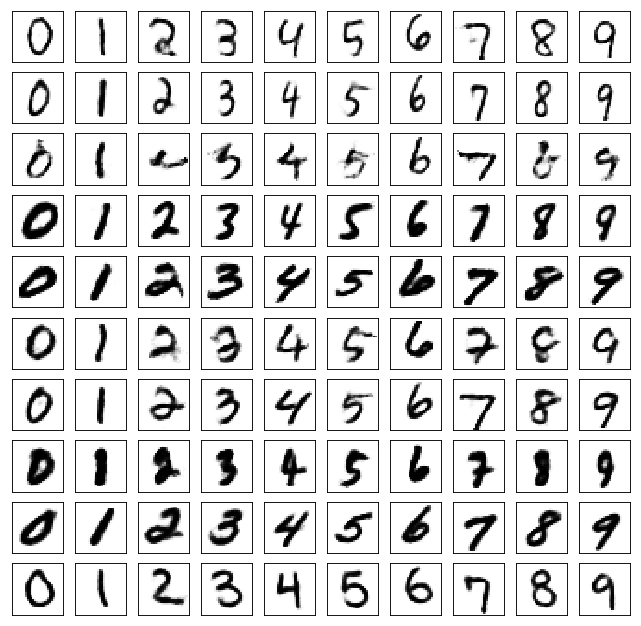

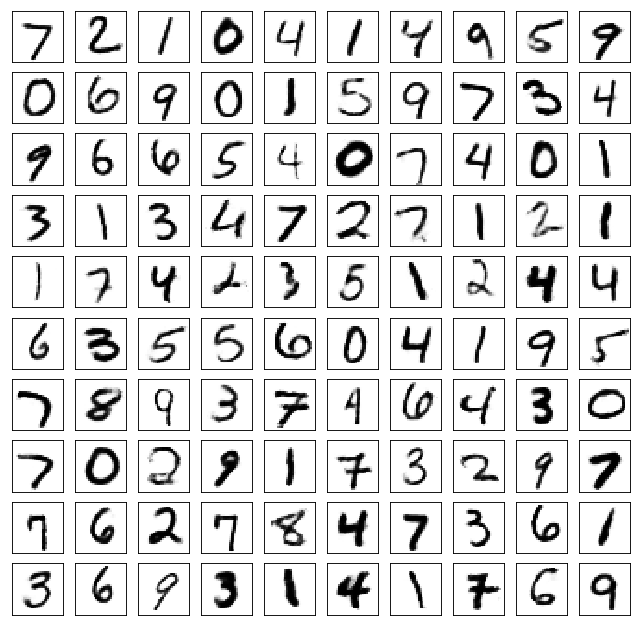

Test losses. E: 0.6940, AE: 0.0546, D: 0.6919


In [16]:
for epoch in range(1001, 2001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [17]:
torch.save(Enc.state_dict(),'caae_enc.2000e.pt')
torch.save(Dec.state_dict(),'caae_dec.2000e.pt')
torch.save(Disc.state_dict(),'caae_disc.2000e.pt')

## Train classifiers on original images and latent representation

In [40]:
class Classifier(nn.Module):
    def __init__(self, sizes, flatten = False):
        super().__init__()
        self.fc = FullyConnected(sizes, 
                                 activation_fn=nn.ReLU(), 
                                 last_fn=nn.LogSoftmax(dim=1),
                                 dropout = 0.2,
                                 bn=True, 
                                 flatten=flatten)
        self.optim = optim.Adam(self.fc.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [41]:
def train_clf(epoch, clf, loader):
    train_loss = 0.0
    train_accuracy = 0.0
    total_samples = 0.0
    clf.train()
    for batch, (data, label) in enumerate(loader):
        clf.optim.zero_grad()
        data = torch.tensor(data).cuda()
        label = torch.tensor(label).cuda()
        
        output = clf(data)
        loss = F.nll_loss(output, label)
        loss.backward()
        clf.optim.step()
        
        train_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        train_accuracy += (pred == label).sum().item()
        total_samples += data.shape[0]

    train_loss /= len(train_data)
    print("Epoch {:2d}: loss {:.4f}, accuracy {:.2f}%".format(epoch, train_loss, 100 * train_accuracy/ total_samples))

In [42]:
def test_clf(epoch, clf, loader):
    test_loss = 0.0
    test_accuracy = 0.0
    total_samples = 0.0
    clf.eval()
    for batch, (data, label) in enumerate(loader):
        data = torch.tensor(data).cuda()
        label = torch.tensor(label).cuda()
        
        output = clf(data)
        loss = F.nll_loss(output, label)
                
        test_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        test_accuracy += (pred == label).sum().item()
        total_samples += data.shape[0]

    test_loss /= len(test_data)
    print("Test  {:2d}: loss {:.4f}, accuracy {:.2f}%".format(epoch, test_loss, 100 * test_accuracy / total_samples))

### Create train/test dataset from latent representation

In [43]:
Enc.eval()
train_data = []
test_data = []
for data, label in train_loader:
    data = data.cuda()
    train_data.append((Enc(data).data.cpu().numpy(), label.data.numpy()))
    
for data, label in test_loader:
    data = data.cuda()
    test_data.append((Enc(data).data.cpu().numpy(), label.data.numpy()))    

### Train classifier on original images

In [44]:
image_clf = Classifier([28*28, 2048, 1024, 512, 10], flatten=True).cuda()
image_clf

Classifier(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=784, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=10, bias=True)
      (13): LogSoftmax()
    )
  )
)

In [45]:
for epoch in range(1,11):
    train_clf(epoch, image_clf, train_loader)
    test_clf(epoch, image_clf, test_loader)

Epoch  1: loss 0.6268, accuracy 87.68%
Test   1: loss 0.2235, accuracy 95.33%
Epoch  2: loss 0.1907, accuracy 95.94%
Test   2: loss 0.1195, accuracy 96.87%
Epoch  3: loss 0.1133, accuracy 97.38%
Test   3: loss 0.0857, accuracy 97.56%
Epoch  4: loss 0.0769, accuracy 98.22%
Test   4: loss 0.0726, accuracy 97.87%
Epoch  5: loss 0.0556, accuracy 98.68%
Test   5: loss 0.0635, accuracy 98.05%
Epoch  6: loss 0.0417, accuracy 99.02%
Test   6: loss 0.0586, accuracy 98.25%
Epoch  7: loss 0.0305, accuracy 99.30%
Test   7: loss 0.0575, accuracy 98.19%
Epoch  8: loss 0.0249, accuracy 99.42%
Test   8: loss 0.0595, accuracy 98.05%
Epoch  9: loss 0.0199, accuracy 99.58%
Test   9: loss 0.0582, accuracy 98.14%
Epoch 10: loss 0.0158, accuracy 99.67%
Test  10: loss 0.0587, accuracy 98.17%


### Train classifier on latent representation

In [46]:
latent_clf = Classifier([prior_size, 2048, 1024, 512, 10]).cuda()
latent_clf

Classifier(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=10, bias=True)
      (13): LogSoftmax()
    )
  )
)

In [47]:
for epoch in range(1,201):
    latent_clf.train()
    train_clf(epoch, latent_clf, train_data)
    latent_clf.eval()
    test_clf(epoch, latent_clf, test_data)

Epoch  1: loss 2.3253, accuracy 10.49%
Test   1: loss 2.3044, accuracy 10.76%
Epoch  2: loss 2.3129, accuracy 10.99%
Test   2: loss 2.2996, accuracy 11.78%
Epoch  3: loss 2.3088, accuracy 11.40%
Test   3: loss 2.2989, accuracy 12.04%
Epoch  4: loss 2.3049, accuracy 11.68%
Test   4: loss 2.2978, accuracy 12.26%
Epoch  5: loss 2.3028, accuracy 11.81%
Test   5: loss 2.2970, accuracy 12.17%
Epoch  6: loss 2.3001, accuracy 12.21%
Test   6: loss 2.2965, accuracy 12.34%
Epoch  7: loss 2.2983, accuracy 12.28%
Test   7: loss 2.2957, accuracy 12.70%
Epoch  8: loss 2.2962, accuracy 12.53%
Test   8: loss 2.2945, accuracy 12.80%
Epoch  9: loss 2.2941, accuracy 12.80%
Test   9: loss 2.2941, accuracy 12.58%
Epoch 10: loss 2.2936, accuracy 12.82%
Test  10: loss 2.2939, accuracy 12.38%
Epoch 11: loss 2.2910, accuracy 13.00%
Test  11: loss 2.2931, accuracy 12.35%
Epoch 12: loss 2.2905, accuracy 12.91%
Test  12: loss 2.2922, accuracy 12.60%
Epoch 13: loss 2.2889, accuracy 13.34%
Test  13: loss 2.2913, ac

Epoch 106: loss 1.9717, accuracy 29.99%
Test  106: loss 2.2745, accuracy 17.12%
Epoch 107: loss 1.9714, accuracy 30.03%
Test  107: loss 2.2769, accuracy 17.24%
Epoch 108: loss 1.9613, accuracy 30.67%
Test  108: loss 2.2772, accuracy 17.60%
Epoch 109: loss 1.9636, accuracy 30.26%
Test  109: loss 2.2772, accuracy 17.73%
Epoch 110: loss 1.9556, accuracy 30.40%
Test  110: loss 2.2827, accuracy 17.17%
Epoch 111: loss 1.9533, accuracy 30.87%
Test  111: loss 2.2787, accuracy 17.12%
Epoch 112: loss 1.9438, accuracy 31.28%
Test  112: loss 2.2809, accuracy 17.26%
Epoch 113: loss 1.9464, accuracy 30.98%
Test  113: loss 2.2824, accuracy 17.36%
Epoch 114: loss 1.9390, accuracy 31.35%
Test  114: loss 2.2836, accuracy 17.25%
Epoch 115: loss 1.9344, accuracy 31.54%
Test  115: loss 2.2806, accuracy 17.45%
Epoch 116: loss 1.9289, accuracy 31.88%
Test  116: loss 2.2857, accuracy 17.15%
Epoch 117: loss 1.9266, accuracy 31.93%
Test  117: loss 2.2836, accuracy 17.18%
Epoch 118: loss 1.9220, accuracy 32.29%


## Style Transfer

In [48]:
n_images = 10

In [49]:
mnist_loader, _ = mnist(batch_size=n_images, transform=mnist_tanh)

In [50]:
imgs, _ = next(iter(mnist_loader))

In [51]:
def plot_styled_images():
    Enc.eval()
    Dec.eval()

    for d in range(10):
        target_digits = to_onehot([d]*n_images, 10).to(device)
        styles = Enc(imgs)
        target_images = Dec(styles, target_digits).cpu().data.numpy().reshape(n_images, 1, 28, 28)
        plot_mnist(target_images, (10,10))

### Original images

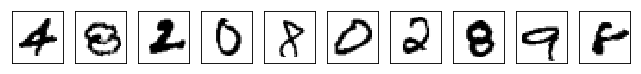

In [52]:
plot_mnist(imgs, (10,10))

### Styled images

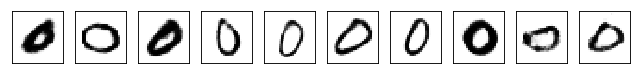

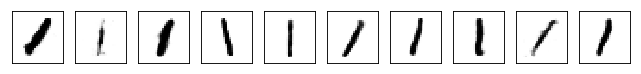

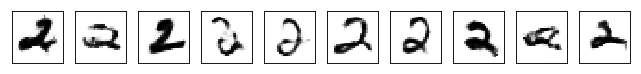

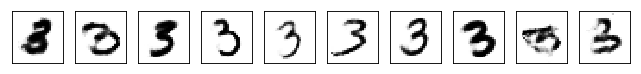

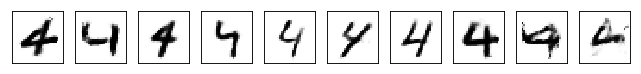

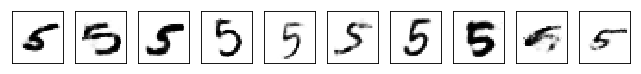

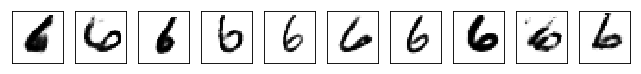

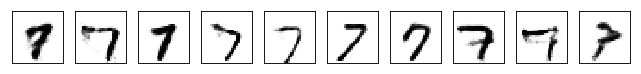

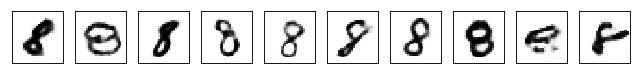

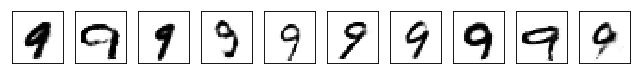

In [53]:
plot_styled_images()